In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from google.cloud import bigquery
import db_dtypes
import scipy.stats as stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
os.environ[
    "GOOGLE_APPLICATION_CREDENTIALS"] = "the-webbing-454111-s0-9a04cc92eadc.json"  # lokalizacja pobranego klucza z punktu 1.4.
client = bigquery.Client()

In [75]:
query = """
SELECT DISTINCT
    country_name,
    iso_3166_1_alpha_3 AS `3 letter country code`,
    AVG(new_deceased) AS `new_deceased`,
    AVG(new_confirmed) AS `new_confirmed`,
    AVG(new_persons_vaccinated) AS `new_persons_vaccinated`,
    MAX(new_tested) as `new_tested`,
    MAX(population) AS `population`, 
    MAX(stringency_index) AS `stringency_index`,
    MAX(gdp_usd) AS `GDP`, 
      Max(gdp_per_capita_usd) AS `gdp_per_capita_usd`,
    MAX(health_expenditure_usd) AS `health_expenditure_usd`,
    AVG(population_density) AS `population density`,
    MAX(life_expectancy) AS `life_expectancy`, 
    CASE 
        WHEN SUM(new_confirmed) = 0 THEN 0 
        ELSE (SUM(new_deceased) * 100) / SUM(new_confirmed) 
    END AS `Deceased to Confirmed cases %`, 
    date,
FROM 
    `bigquery-public-data.covid19_open_data.covid19_open_data`
WHERE 
    aggregation_level = 0
GROUP BY 
    country_name, iso_3166_1_alpha_3, date
ORDER BY 
    country_name
"""
query_disease = client.query(query)
query_disease_result = query_disease.result()
disease_df = query_disease_result.to_dataframe()
#disease_df.dropna(inplace=True)
disease_df.to_csv('results\\prepared_for_3_ex.csv', index=False)


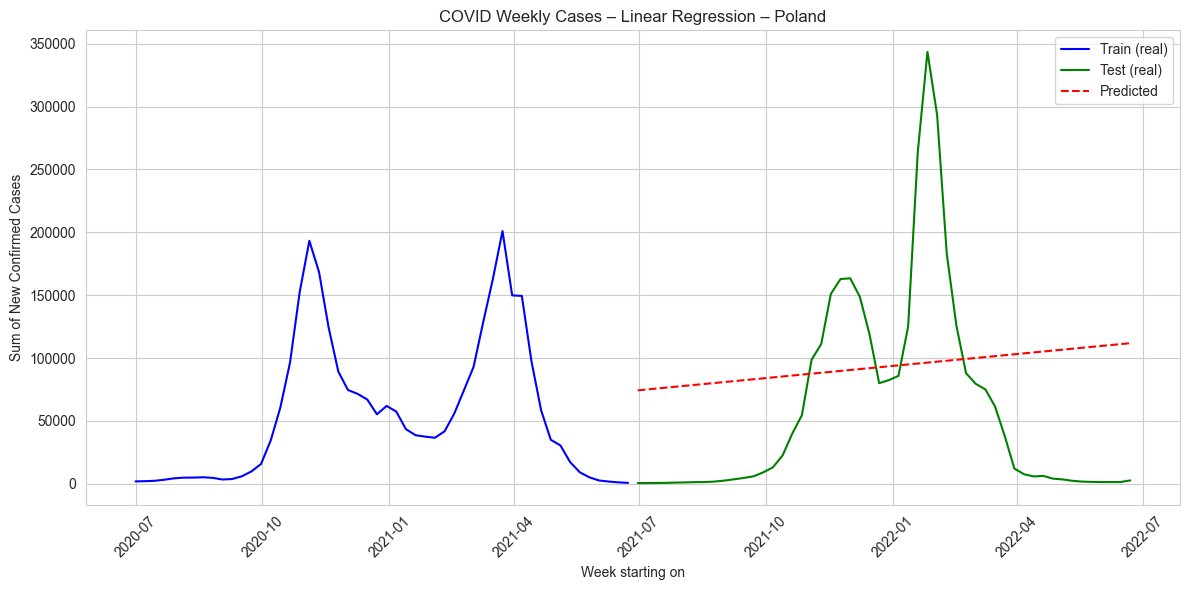

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_confirmed': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_confirmed']
X_test = test_weeks[['week']]
y_test = test_weeks['new_confirmed']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Confirmed Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<h1>Jak widać, do takich zastosowań jak ilość nowych przypadków, regresja liniowa nie jest w stanie się odpowiednio dopasować - jest to zrozumiałe bo jest to funkcja liniowa, a wiadomo, że nowe zachorowania nie będą się zachowywać w sposób liniowy.<h1>

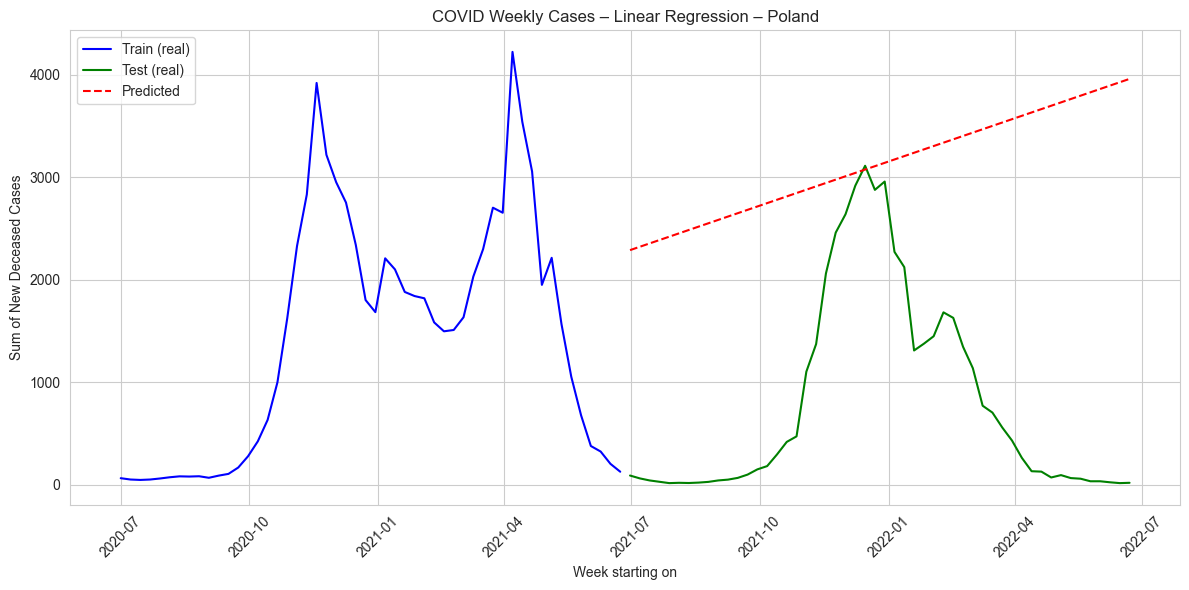

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_deceased': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 51]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 51) & (weekly_df['week'] <= 103)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_deceased']
X_test = test_weeks[['week']]
y_test = test_weeks['new_deceased']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Deceased Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


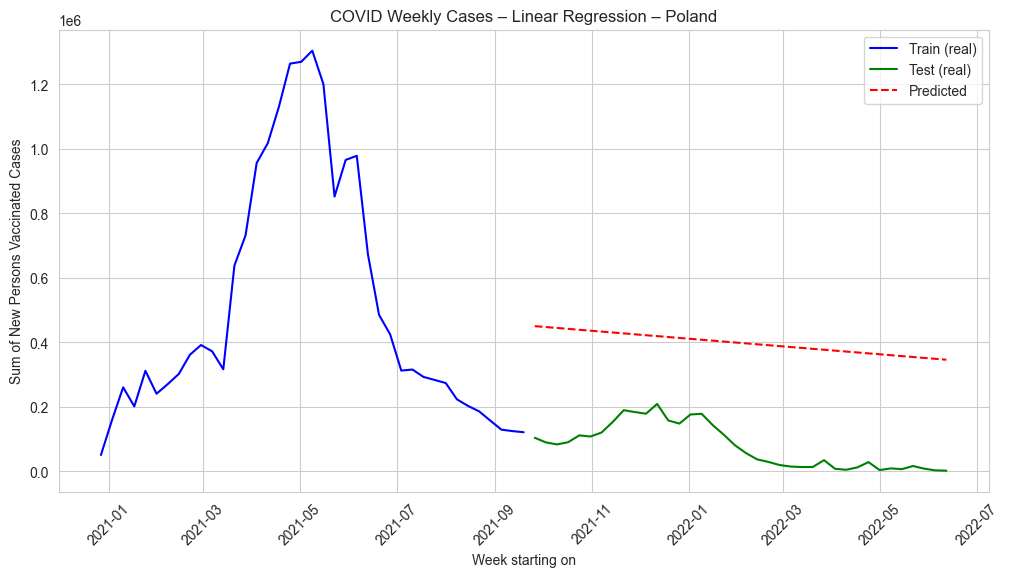

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_persons_vaccinated']
X_test = test_weeks[['week']]
y_test = test_weeks['new_persons_vaccinated']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Persons Vaccinated Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


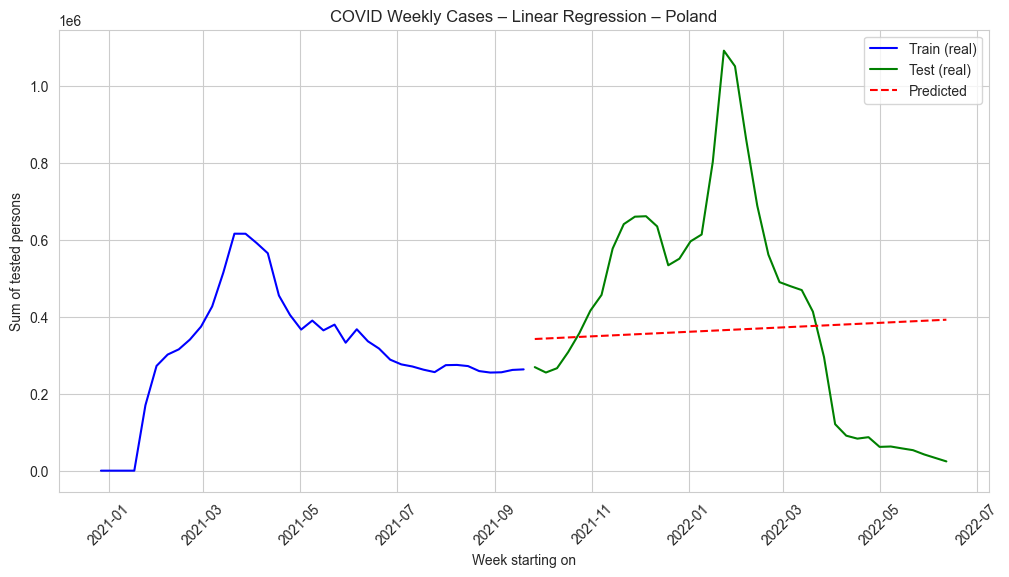

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_tested': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_tested']
X_test = test_weeks[['week']]
y_test = test_weeks['new_tested']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of tested persons')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


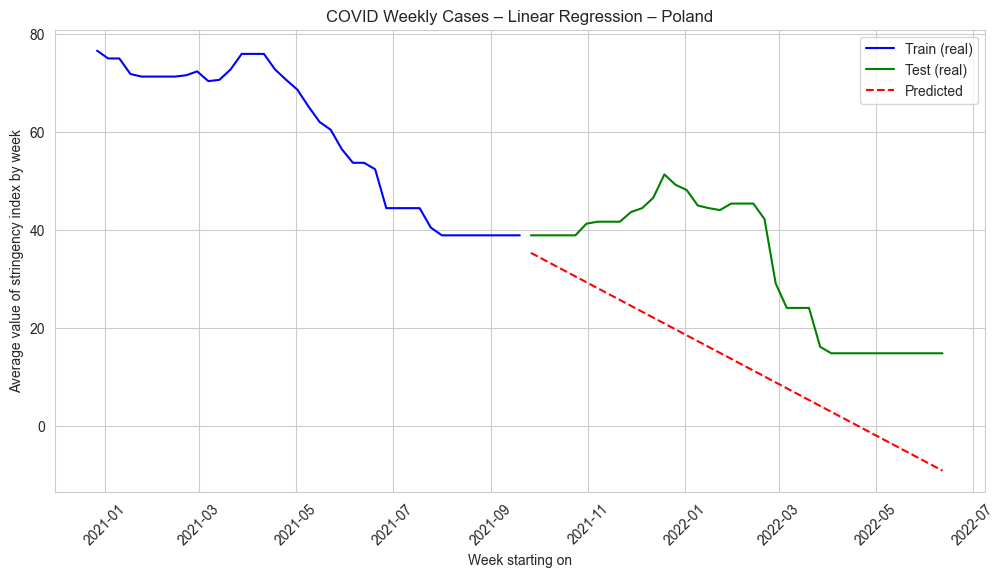

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2020-12-27') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'stringency_index': 'mean',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 38]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 38) & (weekly_df['week'] <= 76)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['stringency_index']
X_test = test_weeks[['week']]
y_test = test_weeks['stringency_index']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Average value of stringency index by week')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


<h1>Widać że tutaj regresja poradziła sobie w sposób trafny. Jendak np. model ten jest za mało zaawansowany aby odcinać wyniki poniżej 0.<h1>

<h1>Nastepnie przeanalizujemy wynik dla przypadku z nowymi zaszczepieniami. Widać było że regresja poległa, źle dobierając wartość wolnego wyrazu b ze wzoru funkcji liniowej, jednak z racji na "liniowość" danych w odpowiednim zakresie czasu, możemy tak dobrać nasze dane, że model poradzi sobie lepiej:<h1>


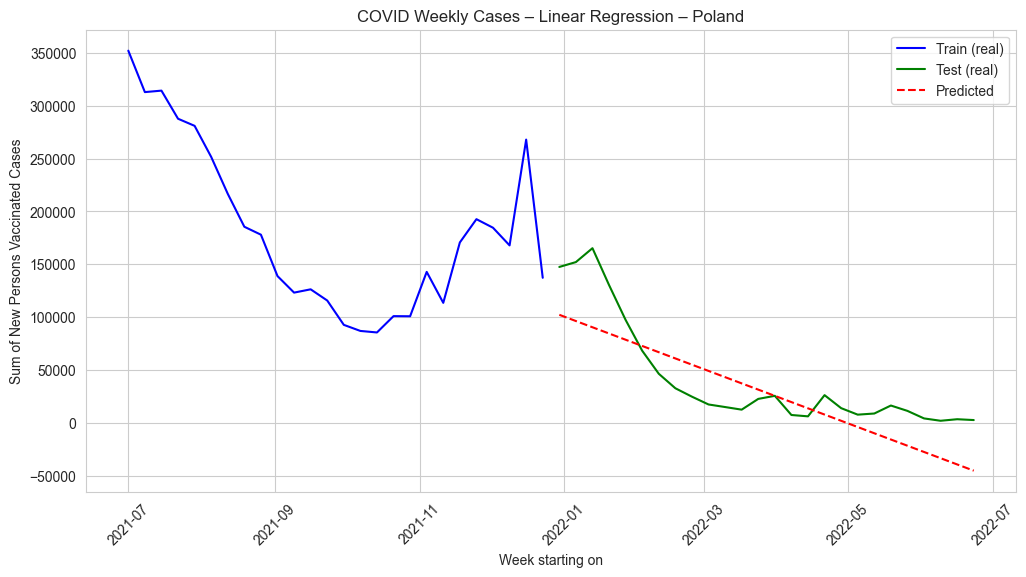

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Filtruj dla jednego kraju (np. Polska)
country = 'Poland'
df = df[df['country_name'] == country]

# Filtrowanie zakresu dat
df = df[(df['date'] >= '2021-07-01') & (df['date'] <= '2022-06-30')]

# Posortuj i dodaj numer tygodnia
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

# Grupuj tygodniowo – i dodaj datę reprezentującą każdy tydzień (np. pierwszy dzień tygodnia)
weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'  # najwcześniejszy dzień w tygodniu jako reprezentant tygodnia
}).reset_index()

# Podział na dane treningowe i testowe
train_weeks = weekly_df[weekly_df['week'] <= 25]  # 52 tygodnie
test_weeks = weekly_df[(weekly_df['week'] > 25) & (weekly_df['week'] <= 51)]

# Dane do regresji
X_train = train_weeks[['week']]
y_train = train_weeks['new_persons_vaccinated']
X_test = test_weeks[['week']]
y_test = test_weeks['new_persons_vaccinated']

# Trening modelu
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Wykres
plt.figure(figsize=(12, 6))
plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
plt.plot(test_weeks['date'], y_pred, label='Predicted', linestyle='--', color='red')
plt.xlabel('Week starting on')
plt.ylabel('Sum of New Persons Vaccinated Cases')
plt.title(f'COVID Weekly Cases – Linear Regression – {country}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


<h1>Jak widać na mniejszym zakresie czasu, jesteśmy w stanie zauważyć poprawność działania i całkiem dobre dopasowanie modelu regresji lioniowej. Niewątpliwie jednak, nie jest to najlepsza metoda dopasowania ani predykcji danych, które nie cechują się liniową charakterystyką. Jednakże, warto ją stosować dla zjawisk cechujących się liniową zależnością: np. siła wyporu od objętości wypartej cieczy itp...  <h1>

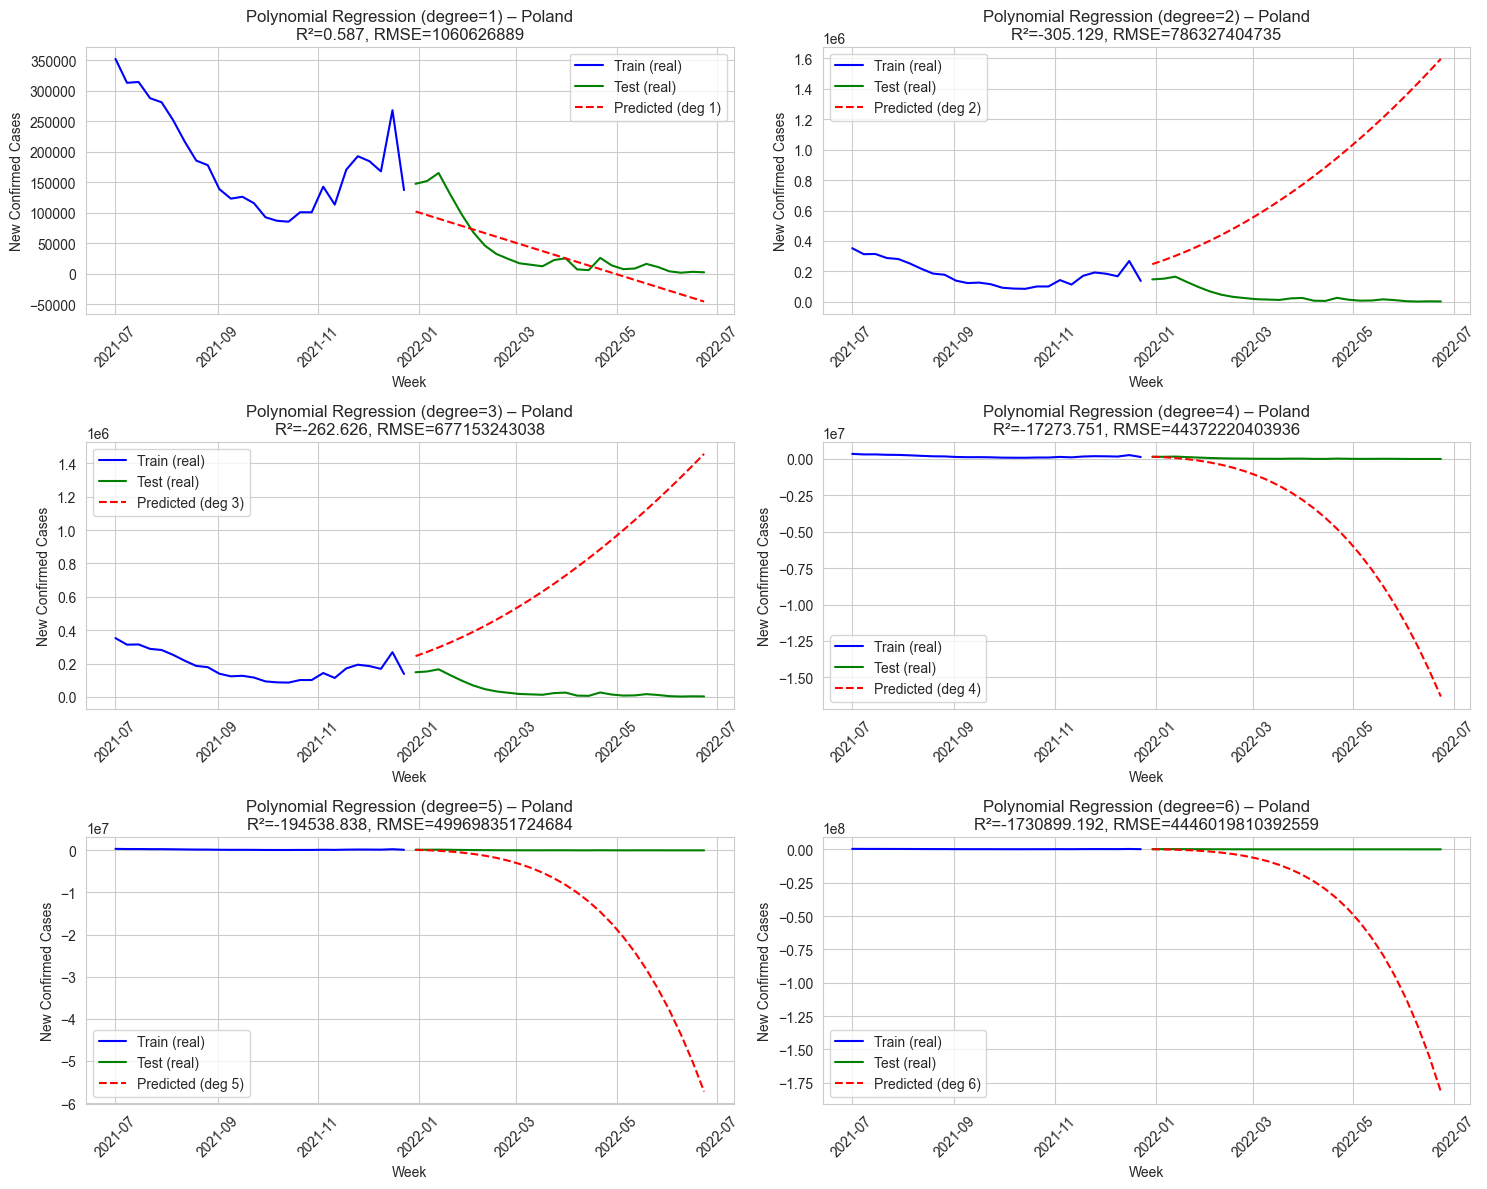

Degree 1: RMSE = 1060626888.64, R² = 0.587
Degree 2: RMSE = 786327404734.67, R² = -305.129
Degree 3: RMSE = 677153243037.68, R² = -262.626
Degree 4: RMSE = 44372220403936.20, R² = -17273.751
Degree 5: RMSE = 499698351724683.69, R² = -194538.838
Degree 6: RMSE = 4446019810392559.00, R² = -1730899.192


In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

# Zakres stopni do przetestowania
degrees = [1, 2, 3, 4, 5, 6]
results = []

plt.figure(figsize=(15, 12))

for i, degree in enumerate(degrees, start=1):
    # Przekształcenie cech
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Trening modelu
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred_poly = model.predict(X_test_poly)

    # Metryki
    rmse = mean_squared_error(y_test, y_pred_poly)
    r2 = r2_score(y_test, y_pred_poly)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(3, 2, i)
    plt.plot(train_weeks['date'], y_train, label='Train (real)', color='blue')
    plt.plot(test_weeks['date'], y_test, label='Test (real)', color='green')
    plt.plot(test_weeks['date'], y_pred_poly, label=f'Predicted (deg {degree})', linestyle='--', color='red')
    plt.title(f'Polynomial Regression (degree={degree}) – {country}\nR²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week')
    plt.ylabel('New Confirmed Cases')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# Porównanie wyników
for deg, rmse, r2 in results:
    print(f"Degree {deg}: RMSE = {rmse:.2f}, R² = {r2:.3f}")


<h1> Powyższy przykład w dobitny sposób pokazuje, iż model regresji wielomianowej nie powinien służyć do przewidywania danych "w przyszłości". Wynika to z prostego powodu, są to modele dobierające wartości współczynnków do wielomianu stopnia n. Metody uczenia modelu operają się na minimalizowaniu najczęściej kwadratu odległości punktów rzeczywistych, od tych obliczonych na podstawie wielomianu. Obszary które nie zostały objęte uczeniem (np. obszar testowy z powyższych testów) posiadają wyższą wartość "x" a co za tym idzie coraz to większe potęgi tych liczb. 

Jeżeli chcemy zastosować model regresji wielomianowej, należy podzielić zbiór w inny sposób - wybierać np. co drugi dzień(tydzień) raz do zbioru uczącego a raz do testowego. W ten sposób dalsze "x" nie będą powodować astronomiczych wartości y, a będą również starać się dopasować do kształtu modelowanego zjawiska. 

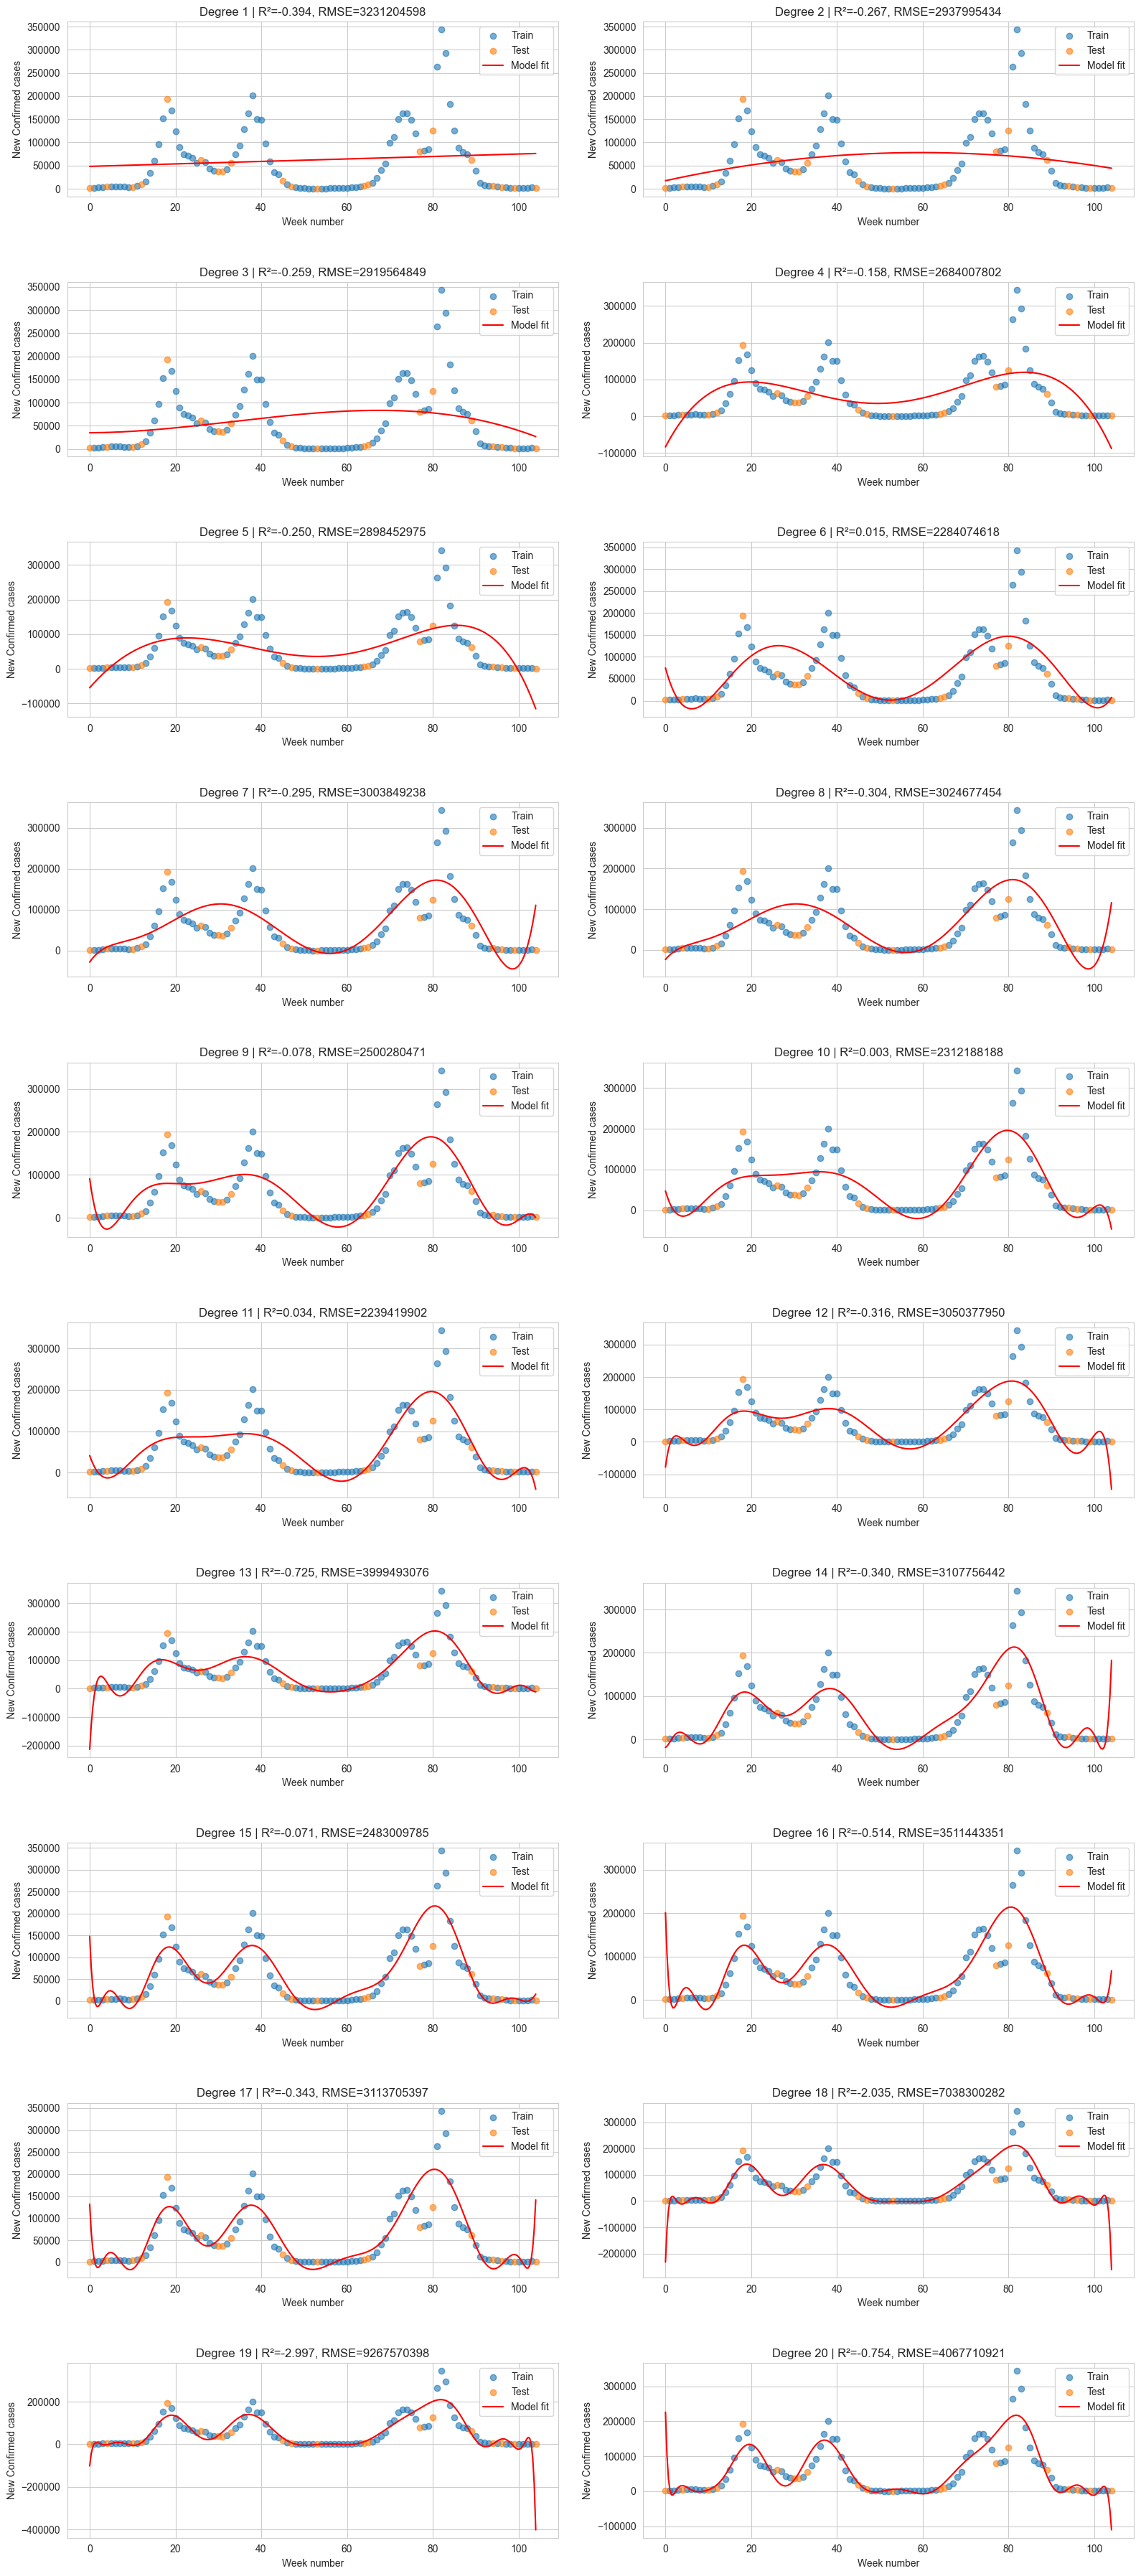

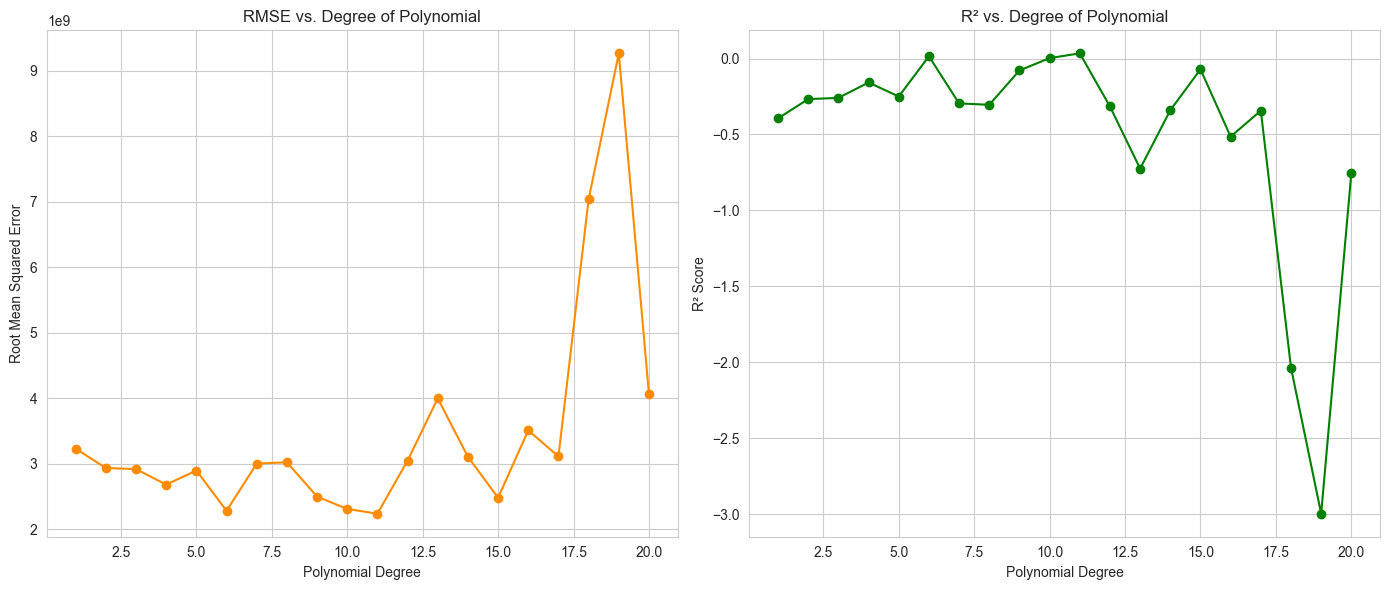


Best model according to RMSE: degree 11, RMSE = 2239419902.02 which has value of R² = 0.034


In [37]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])
country = 'Poland'
df = df[df['country_name'] == country]
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

weekly_df = df.groupby('week').agg({
    'new_confirmed': 'sum',
    'date': 'min'
}).reset_index()

# Dane wejściowe
X = weekly_df[['week']]
y = weekly_df['new_confirmed']

# Losowy podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Regresje dla stopni 1–20
max_degree = 20
results = []

plt.figure(figsize=(16, 36)) 

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(10, 2, degree)
    plt.scatter(X_train, y_train, label='Train', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test', alpha=0.6)

    x_range = np.linspace(X['week'].min(), X['week'].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    x_range_poly = poly.transform(x_range_scaled)
    y_range_pred = model.predict(x_range_poly)
    plt.plot(x_range, y_range_pred, color='red', label='Model fit')

    plt.title(f'Degree {degree} | R²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week number')
    plt.ylabel('New Confirmed cases')
    plt.legend()
    plt.grid(True)

plt.tight_layout(h_pad=4.0, w_pad=2.5)
plt.show()

# --- Wykresy RMSE i R² ---
degrees = [deg for deg, _, _ in results]
rmses = [rmse for _, rmse, _ in results]
r2s = [r2 for _, _, r2 in results]

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(degrees, rmses, marker='o', color='darkorange')
plt.title('RMSE vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)

# R²
plt.subplot(1, 2, 2)
plt.plot(degrees, r2s, marker='o', color='green')
plt.title('R² vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Najlepszy model
best_by_rmse = min(results, key=lambda x: x[1])
print(f"\nBest model according to RMSE: degree {best_by_rmse[0]}, RMSE = {best_by_rmse[1]:.2f} which has value of R² = {best_by_rmse[2]:.3f}")


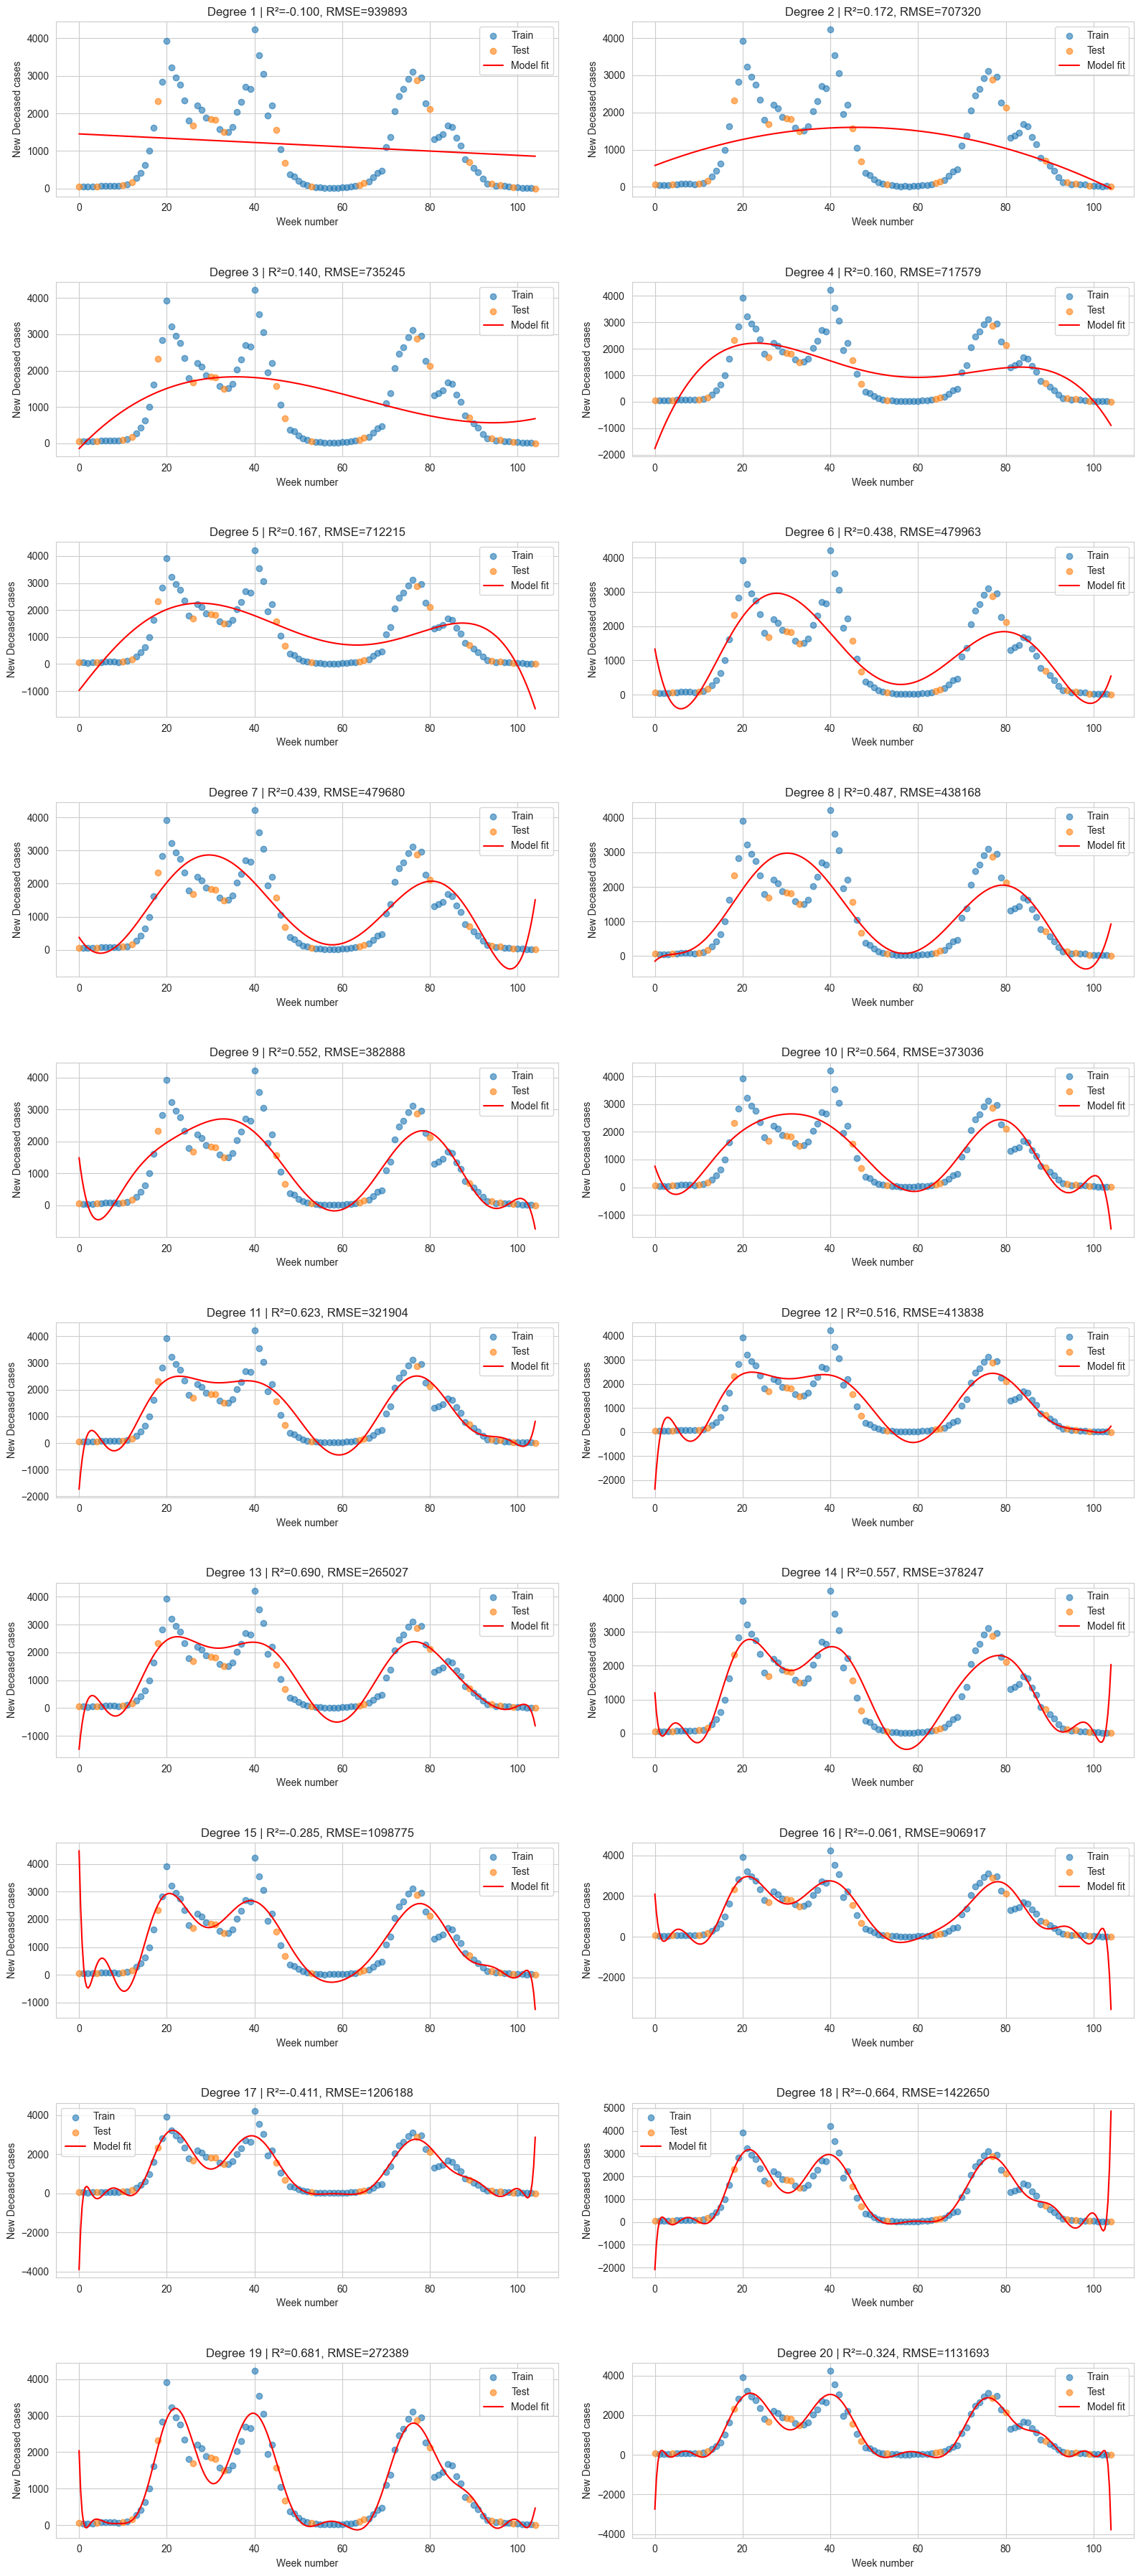

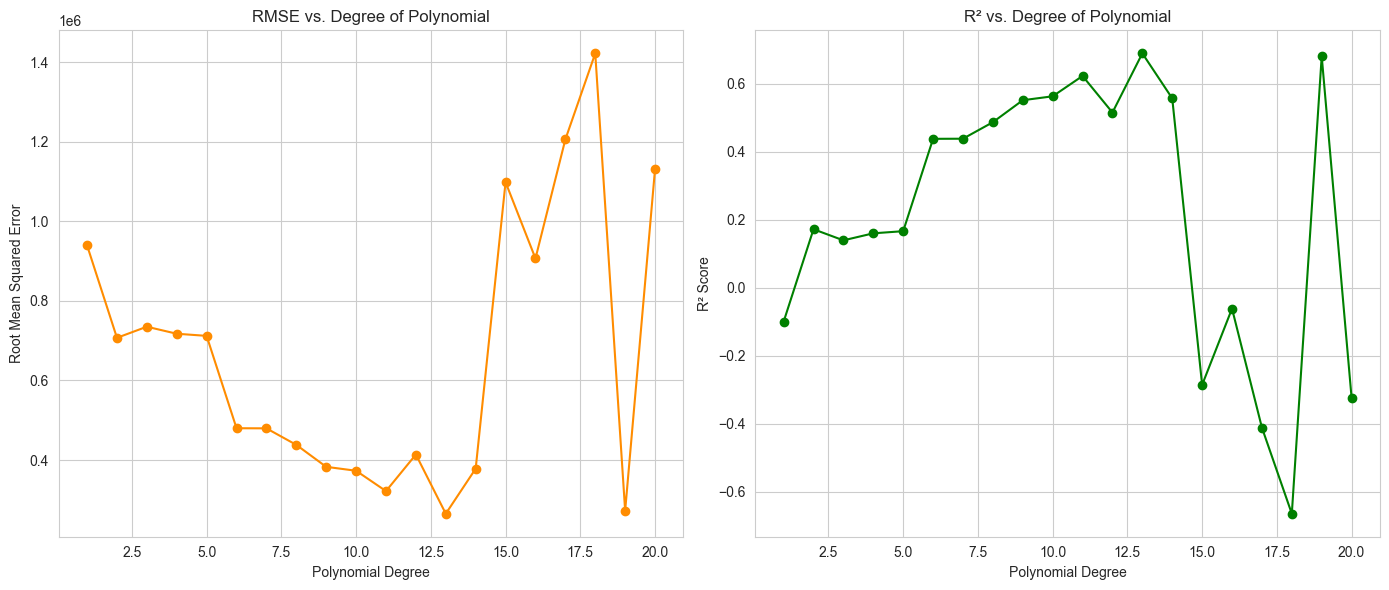


Best model according to RMSE: degree 13, RMSE = 265027.42 which has value of R² = 0.690


In [33]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])
country = 'Poland'
df = df[df['country_name'] == country]
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

weekly_df = df.groupby('week').agg({
    'new_deceased': 'sum',
    'date': 'min'
}).reset_index()

# Dane wejściowe
X = weekly_df[['week']]
y = weekly_df['new_deceased']

# Losowy podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Regresje dla stopni 1–20
max_degree = 20
results = []

plt.figure(figsize=(16, 36)) 

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(10, 2, degree)
    plt.scatter(X_train, y_train, label='Train', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test', alpha=0.6)

    x_range = np.linspace(X['week'].min(), X['week'].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    x_range_poly = poly.transform(x_range_scaled)
    y_range_pred = model.predict(x_range_poly)
    plt.plot(x_range, y_range_pred, color='red', label='Model fit')

    plt.title(f'Degree {degree} | R²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week number')
    plt.ylabel('New Deceased cases')
    plt.legend()
    plt.grid(True)

plt.tight_layout(h_pad=4.0, w_pad=2.5)
plt.show()

# --- Wykresy RMSE i R² ---
degrees = [deg for deg, _, _ in results]
rmses = [rmse for _, rmse, _ in results]
r2s = [r2 for _, _, r2 in results]

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(degrees, rmses, marker='o', color='darkorange')
plt.title('RMSE vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)

# R²
plt.subplot(1, 2, 2)
plt.plot(degrees, r2s, marker='o', color='green')
plt.title('R² vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Najlepszy model
best_by_rmse = min(results, key=lambda x: x[1])
print(f"\nBest model according to RMSE: degree {best_by_rmse[0]}, RMSE = {best_by_rmse[1]:.2f} which has value of R² = {best_by_rmse[2]:.3f}")


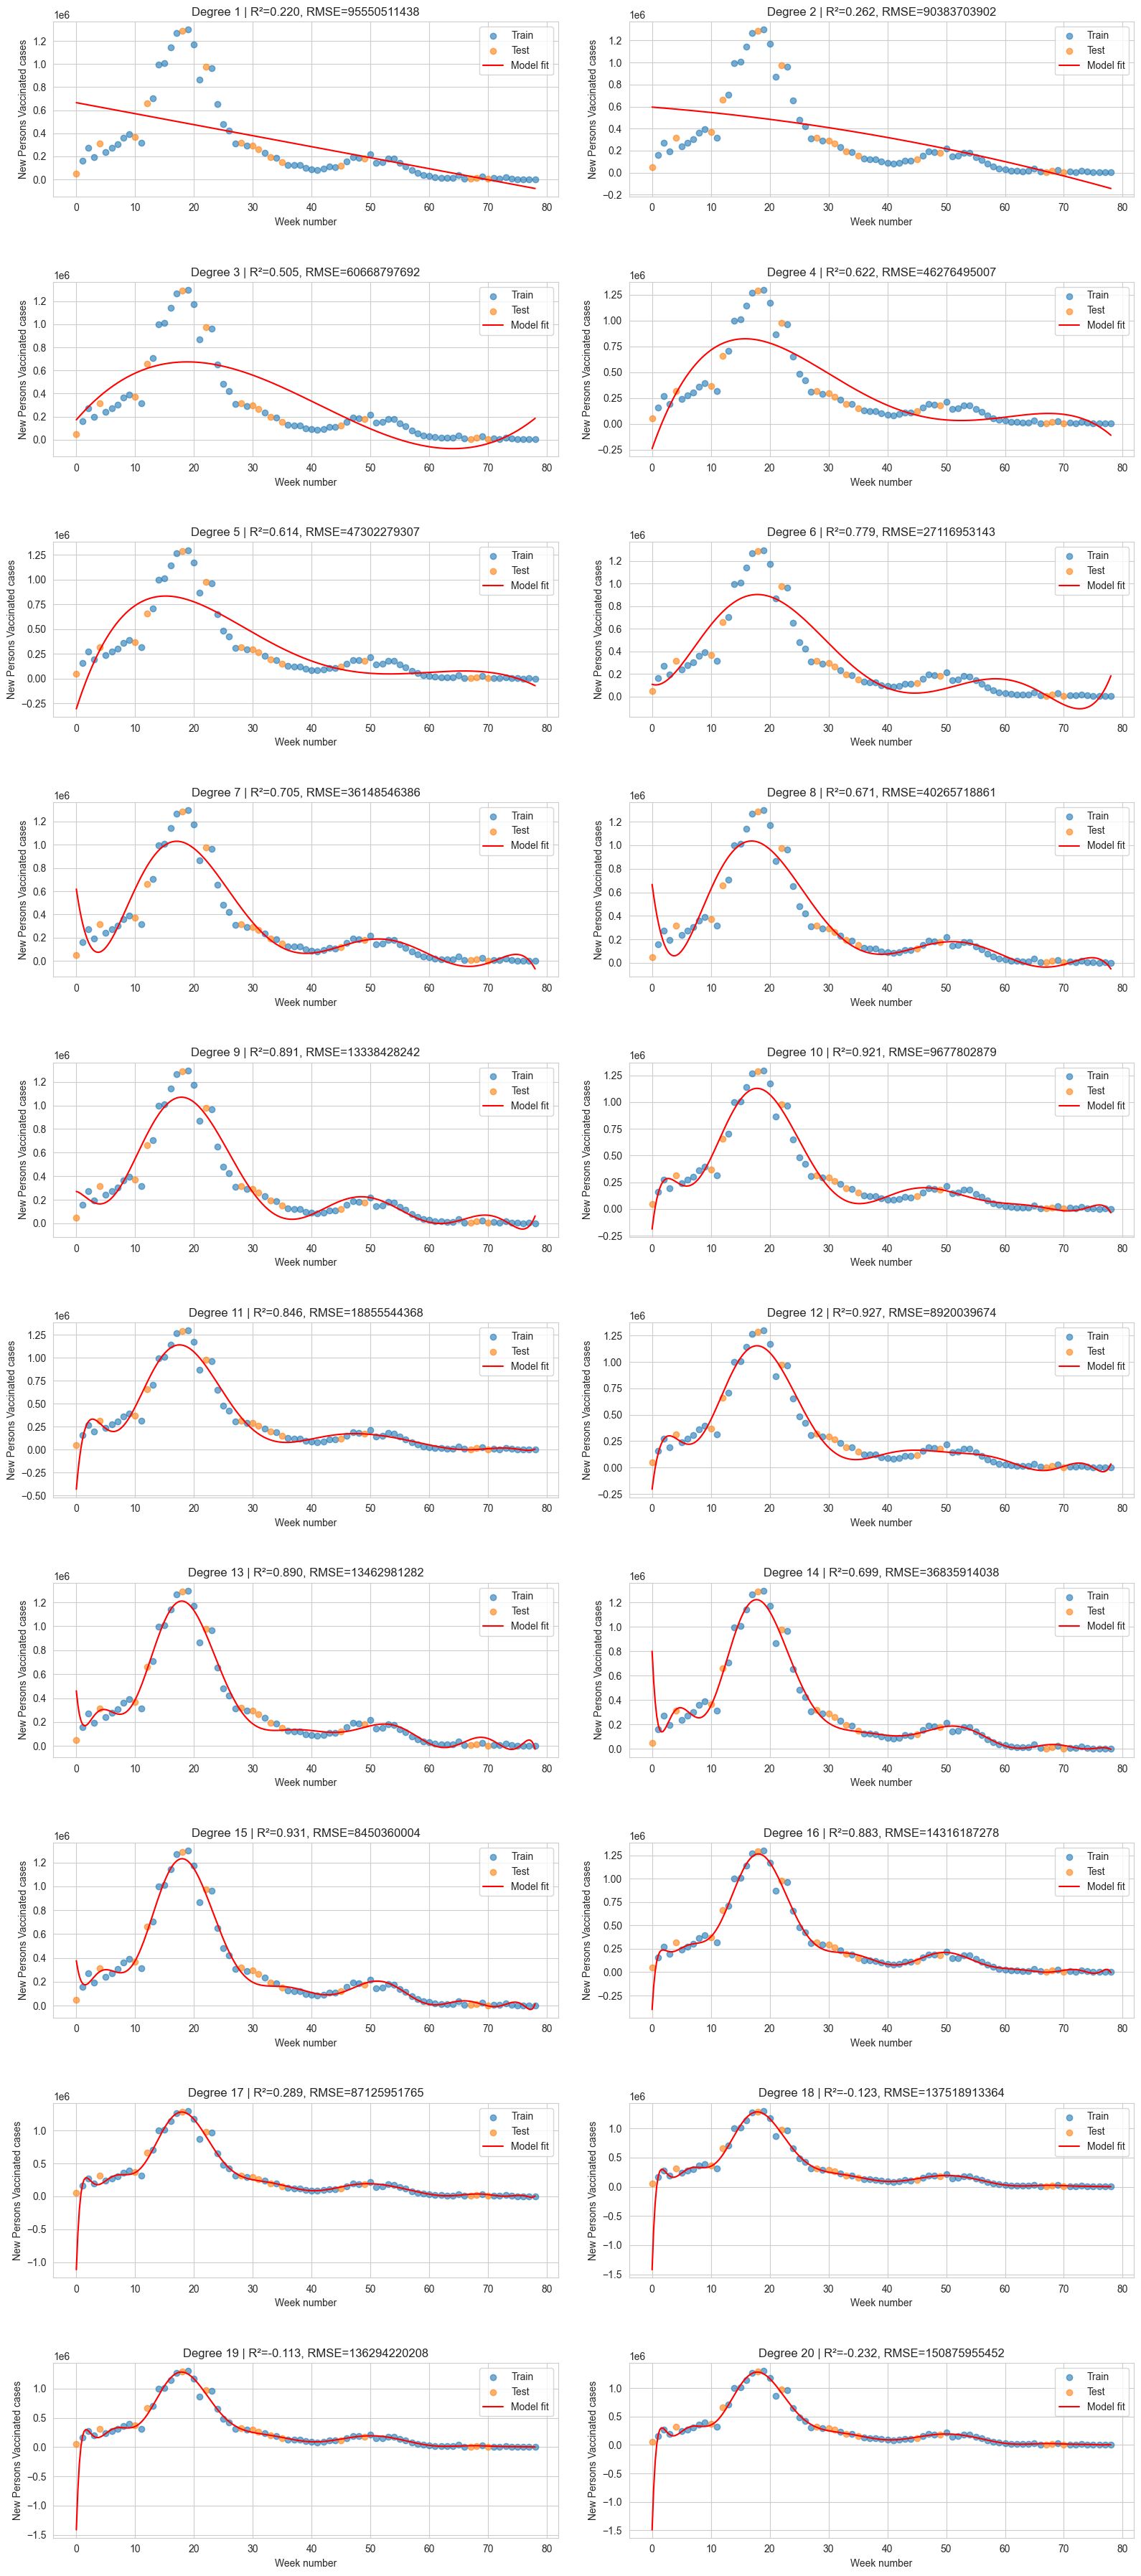

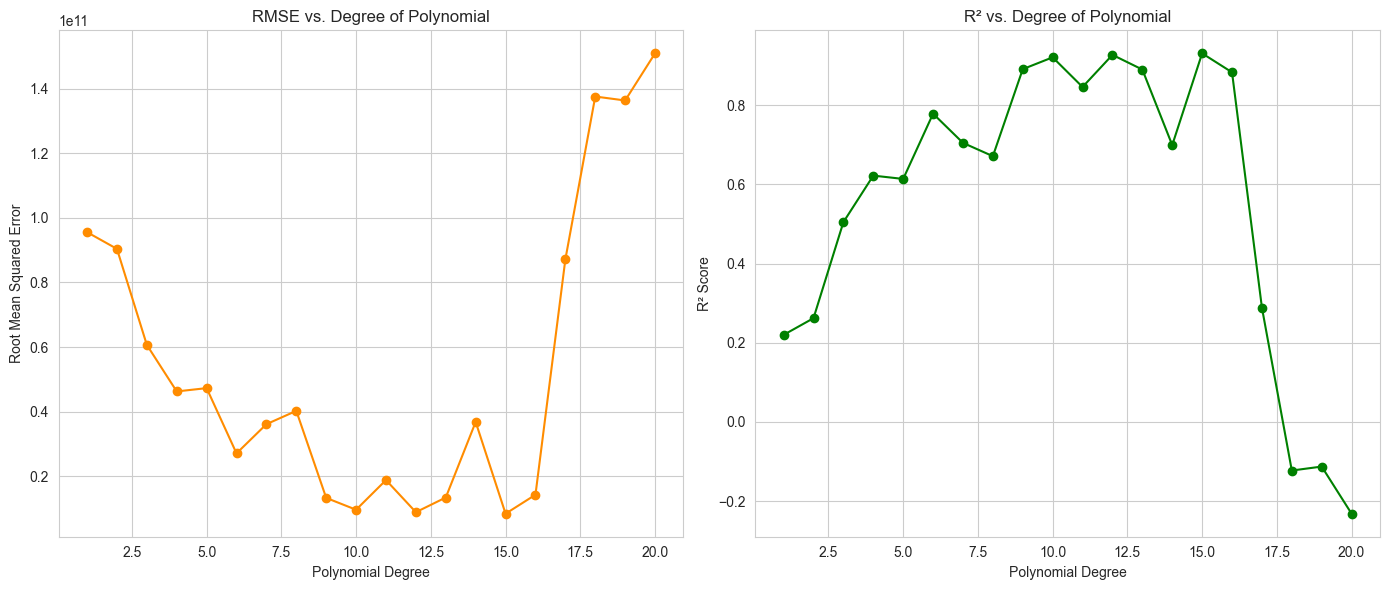


Best model according to RMSE: degree 15, RMSE = 8450360003.64 which has value of R² = 0.931


In [32]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])
country = 'Poland'
df = df[df['country_name'] == country]
df = df[(df['date'] >= '2020-12-28') & (df['date'] <= '2022-06-30')]
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

weekly_df = df.groupby('week').agg({
    'new_persons_vaccinated': 'sum',
    'date': 'min'
}).reset_index()

# Dane wejściowe
X = weekly_df[['week']]
y = weekly_df['new_persons_vaccinated']

# Losowy podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Regresje dla stopni 1–20
max_degree = 20
results = []

plt.figure(figsize=(16, 36)) 

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(10, 2, degree)
    plt.scatter(X_train, y_train, label='Train', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test', alpha=0.6)

    x_range = np.linspace(X['week'].min(), X['week'].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    x_range_poly = poly.transform(x_range_scaled)
    y_range_pred = model.predict(x_range_poly)
    plt.plot(x_range, y_range_pred, color='red', label='Model fit')

    plt.title(f'Degree {degree} | R²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week number')
    plt.ylabel('New Persons Vaccinated cases')
    plt.legend()
    plt.grid(True)

plt.tight_layout(h_pad=4.0, w_pad=2.5)
plt.show()

# --- Wykresy RMSE i R² ---
degrees = [deg for deg, _, _ in results]
rmses = [rmse for _, rmse, _ in results]
r2s = [r2 for _, _, r2 in results]

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(degrees, rmses, marker='o', color='darkorange')
plt.title('RMSE vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)

# R²
plt.subplot(1, 2, 2)
plt.plot(degrees, r2s, marker='o', color='green')
plt.title('R² vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Najlepszy model
best_by_rmse = min(results, key=lambda x: x[1])
print(f"\nBest model according to RMSE: degree {best_by_rmse[0]}, RMSE = {best_by_rmse[1]:.2f} which has value of R² = {best_by_rmse[2]:.3f}")


Finlandia Kongo?

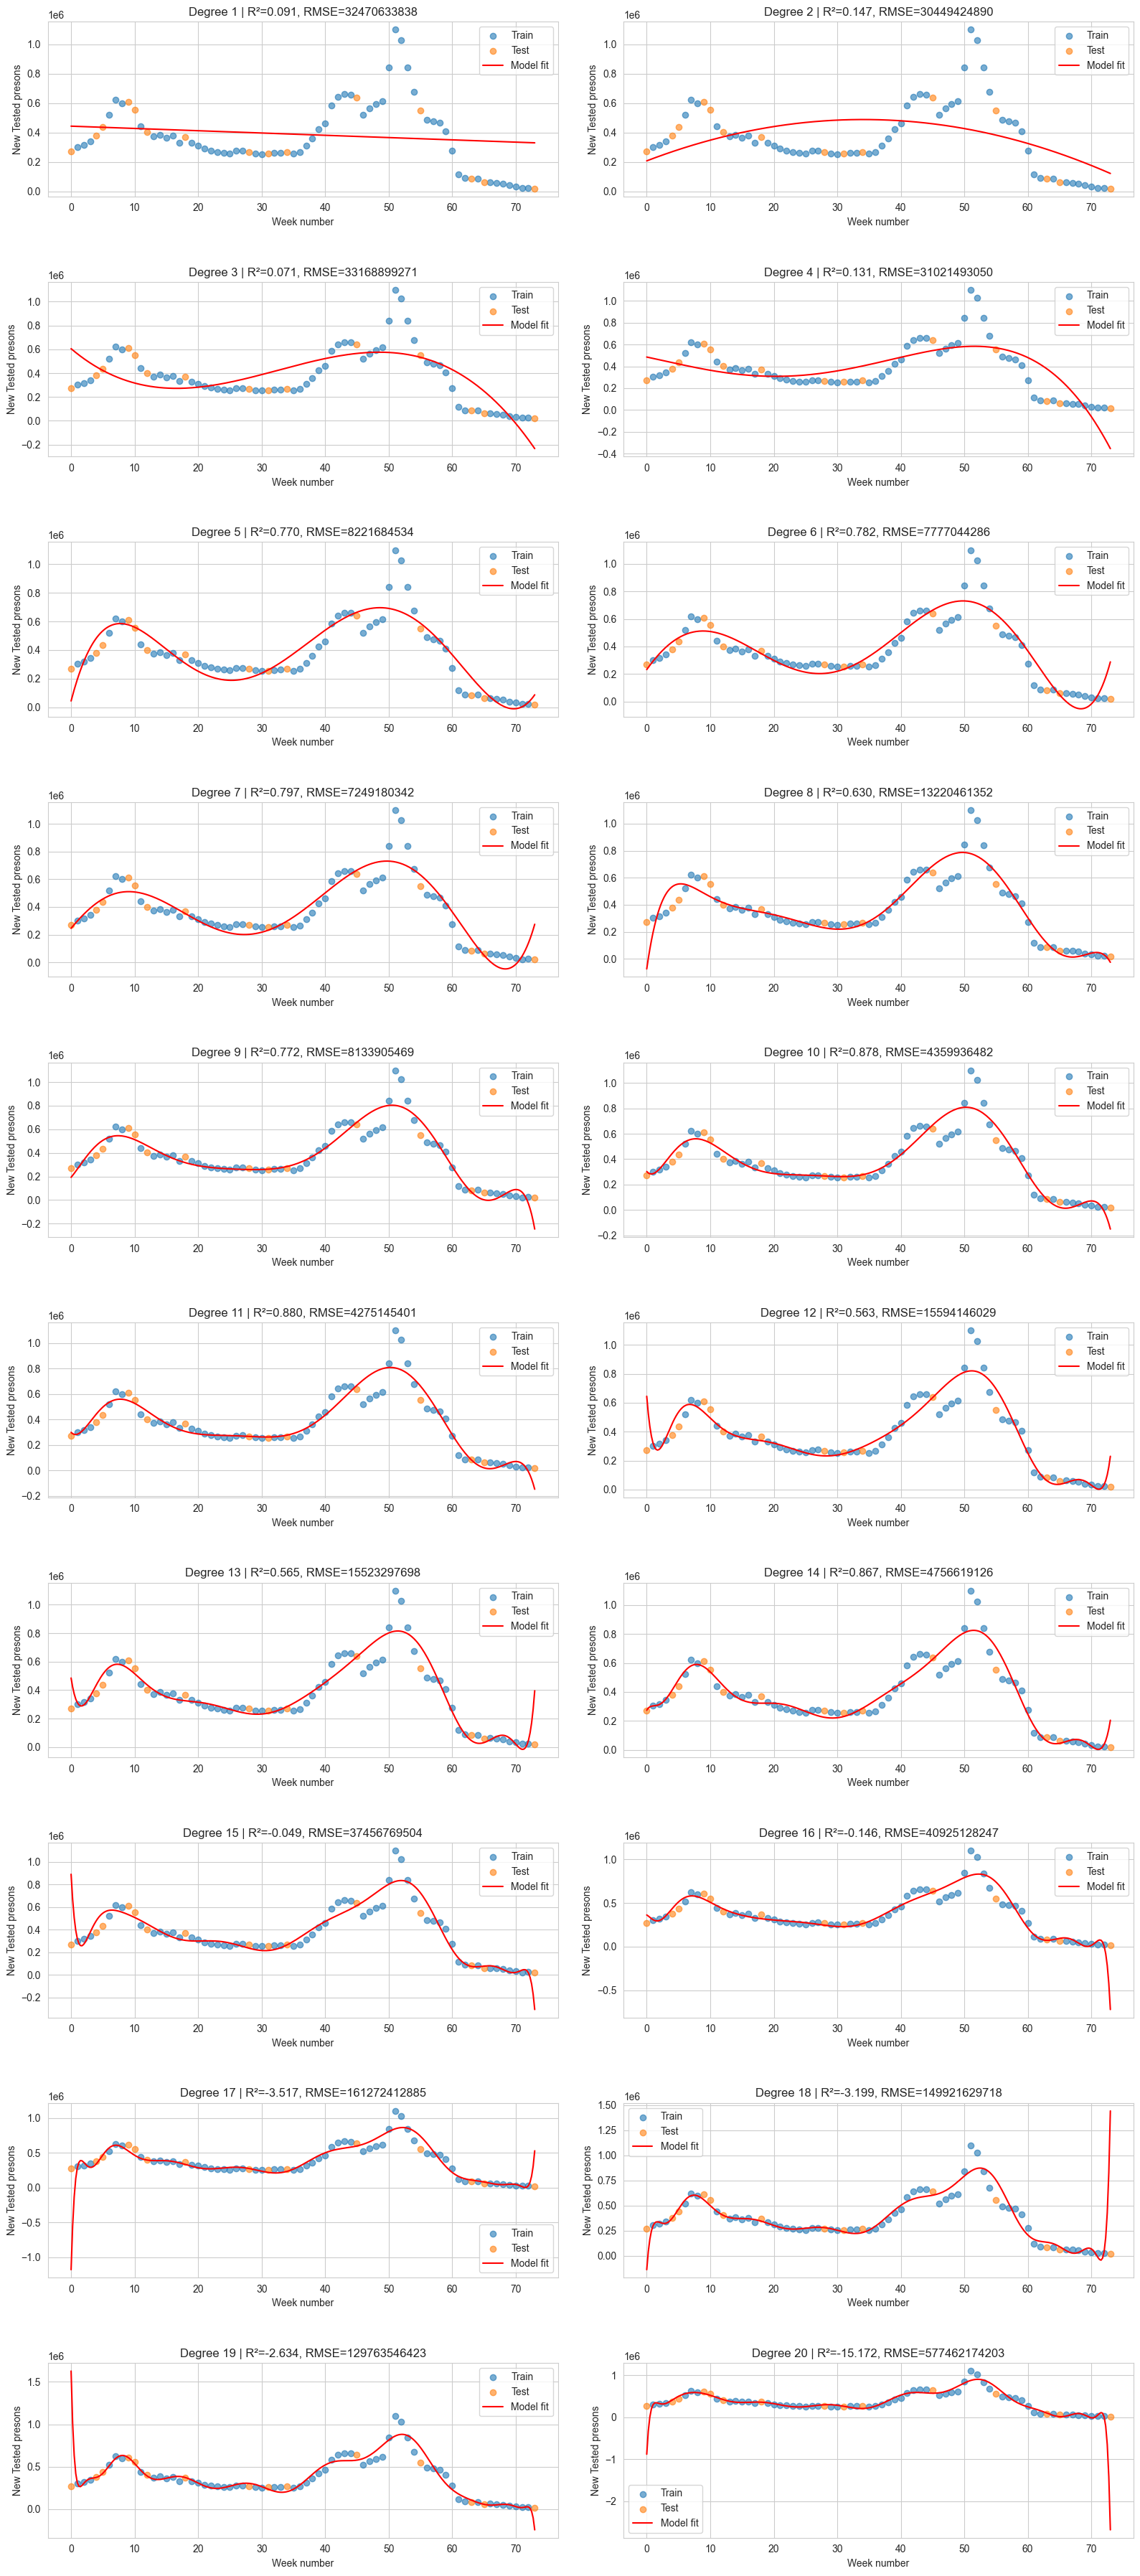

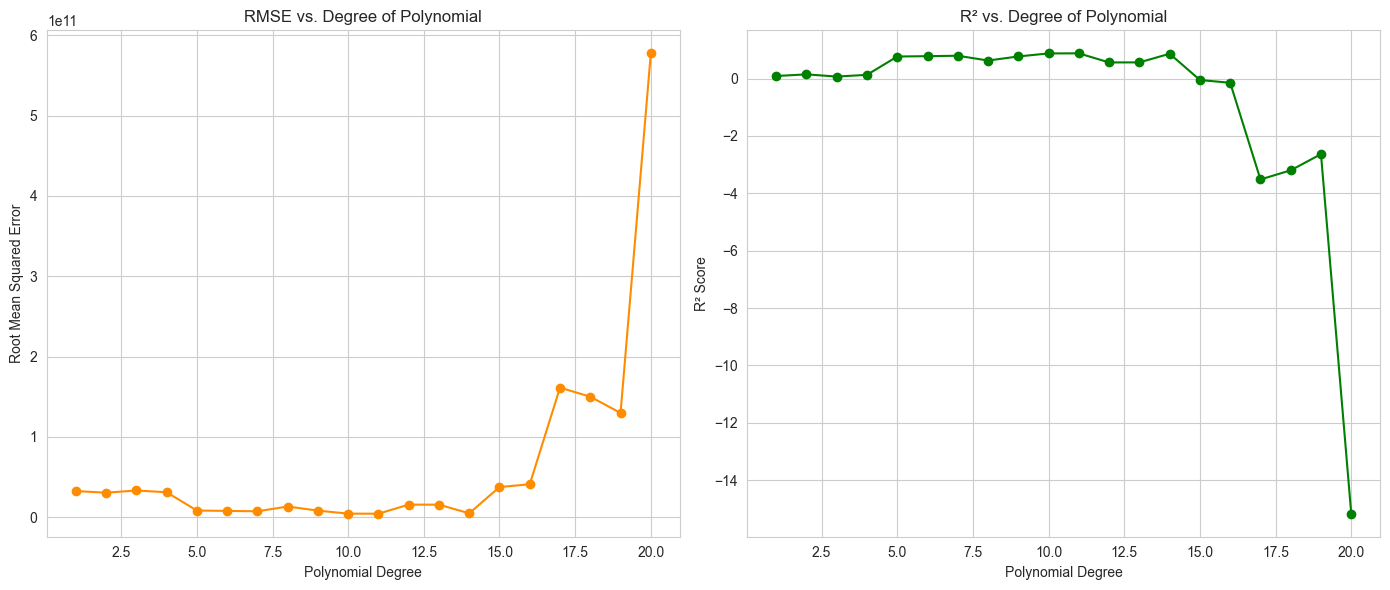


Best model according to RMSE: degree 11, RMSE = 4275145400.94 which has value of R² = 0.880


In [40]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])
country = 'Poland'
df = df[df['country_name'] == country]
df = df[(df['date'] >= '2021-02-01') & (df['date'] <= '2022-06-30')]
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

weekly_df = df.groupby('week').agg({
    'new_tested': 'sum',
    'date': 'min'
}).reset_index()

# Dane wejściowe
X = weekly_df[['week']]
y = weekly_df['new_tested']

# Losowy podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Regresje dla stopni 1–20
max_degree = 20
results = []

plt.figure(figsize=(16, 36)) 

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(10, 2, degree)
    plt.scatter(X_train, y_train, label='Train', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test', alpha=0.6)

    x_range = np.linspace(X['week'].min(), X['week'].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    x_range_poly = poly.transform(x_range_scaled)
    y_range_pred = model.predict(x_range_poly)
    plt.plot(x_range, y_range_pred, color='red', label='Model fit')

    plt.title(f'Degree {degree} | R²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week number')
    plt.ylabel('New Tested presons')
    plt.legend()
    plt.grid(True)

plt.tight_layout(h_pad=4.0, w_pad=2.5)
plt.show()

# --- Wykresy RMSE i R² ---
degrees = [deg for deg, _, _ in results]
rmses = [rmse for _, rmse, _ in results]
r2s = [r2 for _, _, r2 in results]

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(degrees, rmses, marker='o', color='darkorange')
plt.title('RMSE vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)

# R²
plt.subplot(1, 2, 2)
plt.plot(degrees, r2s, marker='o', color='green')
plt.title('R² vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Najlepszy model
best_by_rmse = min(results, key=lambda x: x[1])
print(f"\nBest model according to RMSE: degree {best_by_rmse[0]}, RMSE = {best_by_rmse[1]:.2f} which has value of R² = {best_by_rmse[2]:.3f}")


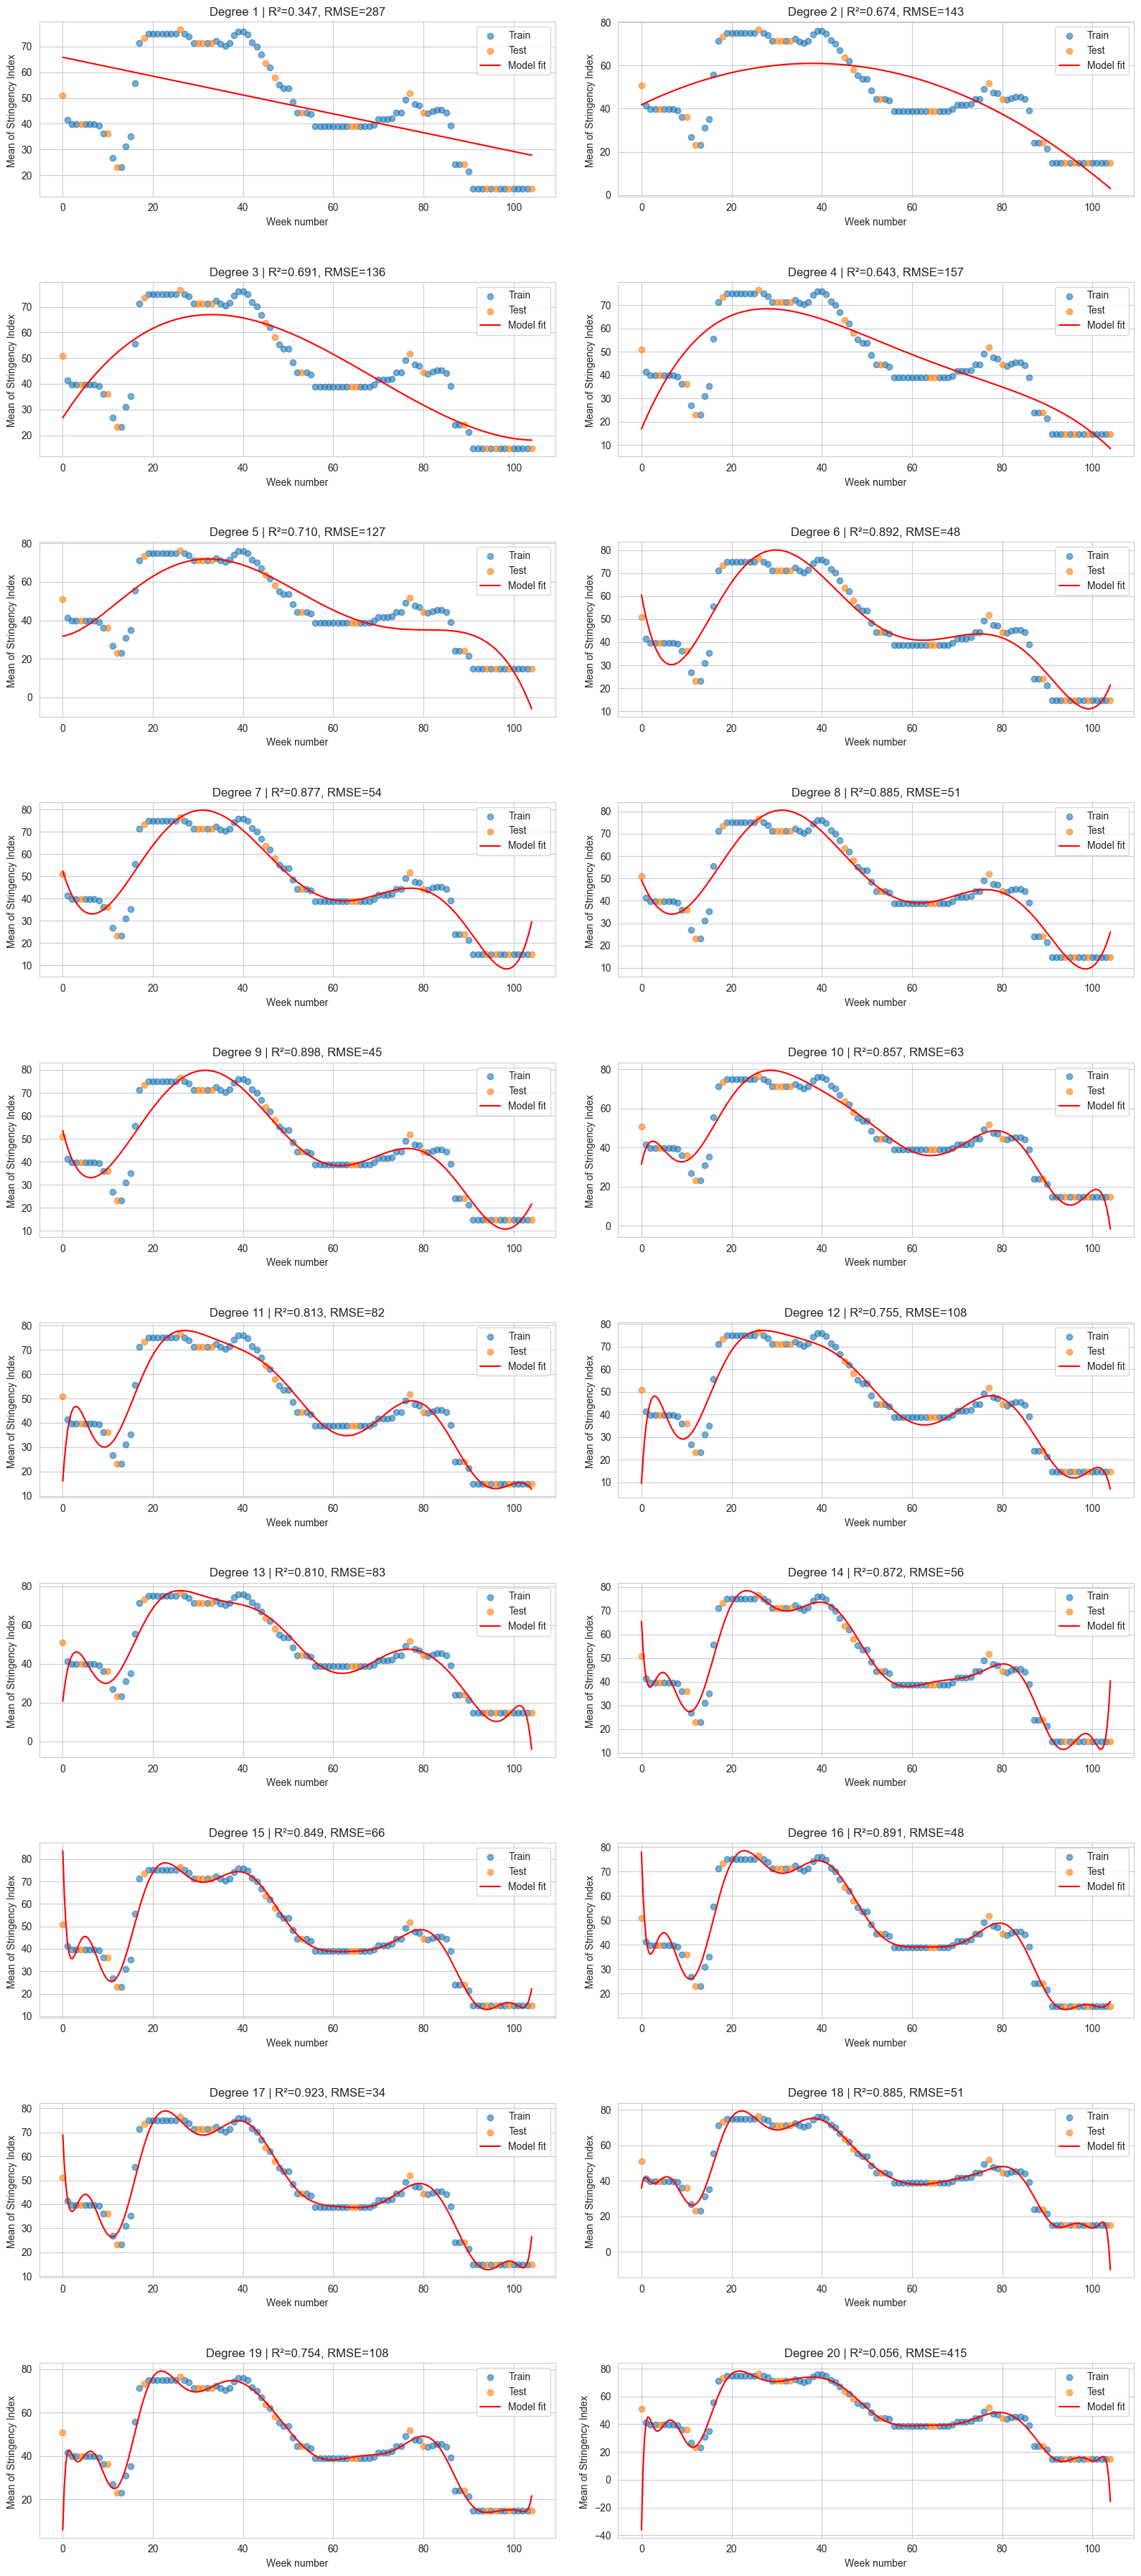

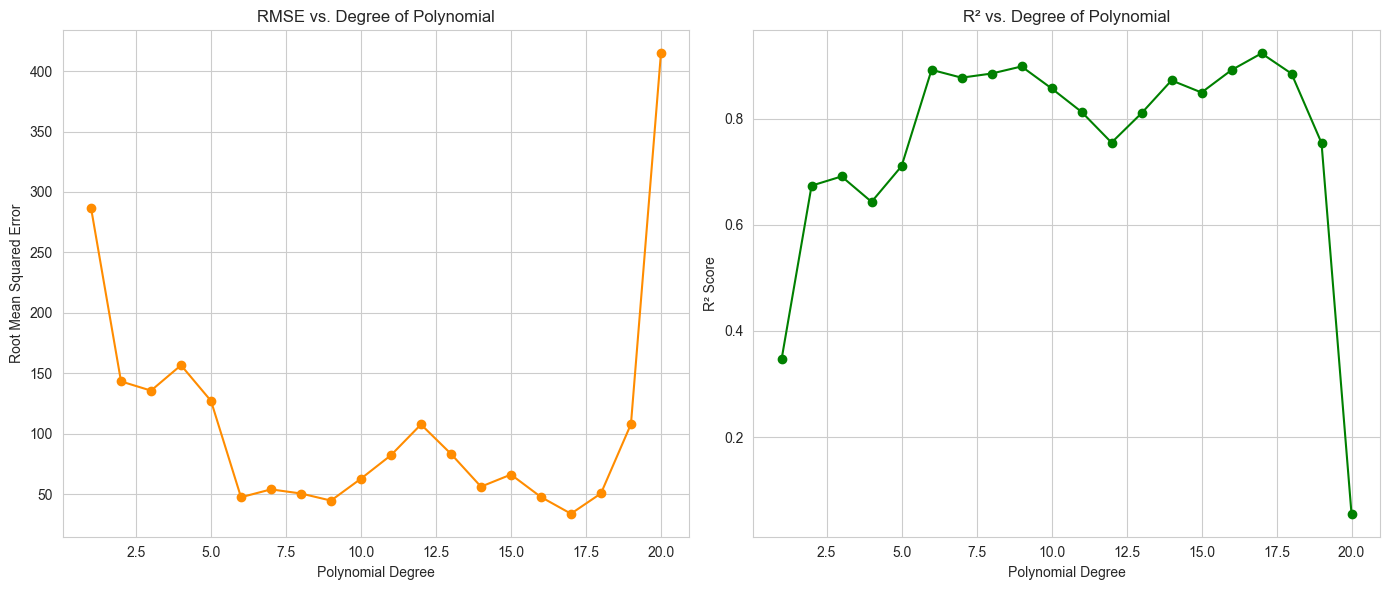


Best model according to RMSE: degree 17, RMSE = 33.91 which has value of R² = 0.923


In [41]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])
country = 'Poland'
df = df[df['country_name'] == country]
df = df[(df['date'] >= '2020-07-01') & (df['date'] <= '2022-06-30')]
df = df.sort_values('date')
df['week'] = ((df['date'] - df['date'].min()).dt.days // 7)

weekly_df = df.groupby('week').agg({
    'stringency_index': 'mean',
    'date': 'min'
}).reset_index()

# Dane wejściowe
X = weekly_df[['week']]
y = weekly_df['stringency_index']

# Losowy podział
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skalowanie
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.values)
X_test_scaled = scaler.transform(X_test.values)

# Regresje dla stopni 1–20
max_degree = 20
results = []

plt.figure(figsize=(16, 36)) 

for degree in range(1, max_degree + 1):
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_test_poly = poly.transform(X_test_scaled)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    y_pred = model.predict(X_test_poly)

    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append((degree, rmse, r2))

    # Wykres
    plt.subplot(10, 2, degree)
    plt.scatter(X_train, y_train, label='Train', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test', alpha=0.6)

    x_range = np.linspace(X['week'].min(), X['week'].max(), 300).reshape(-1, 1)
    x_range_scaled = scaler.transform(x_range)
    x_range_poly = poly.transform(x_range_scaled)
    y_range_pred = model.predict(x_range_poly)
    plt.plot(x_range, y_range_pred, color='red', label='Model fit')

    plt.title(f'Degree {degree} | R²={r2:.3f}, RMSE={rmse:.0f}')
    plt.xlabel('Week number')
    plt.ylabel('Mean of Stringency Index ')
    plt.legend()
    plt.grid(True)

plt.tight_layout(h_pad=4.0, w_pad=2.5)
plt.show()

# --- Wykresy RMSE i R² ---
degrees = [deg for deg, _, _ in results]
rmses = [rmse for _, rmse, _ in results]
r2s = [r2 for _, _, r2 in results]

plt.figure(figsize=(14, 6))

# RMSE
plt.subplot(1, 2, 1)
plt.plot(degrees, rmses, marker='o', color='darkorange')
plt.title('RMSE vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error')
plt.grid(True)

# R²
plt.subplot(1, 2, 2)
plt.plot(degrees, r2s, marker='o', color='green')
plt.title('R² vs. Degree of Polynomial')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Najlepszy model
best_by_rmse = min(results, key=lambda x: x[1])
print(f"\nBest model according to RMSE: degree {best_by_rmse[0]}, RMSE = {best_by_rmse[1]:.2f} which has value of R² = {best_by_rmse[2]:.3f}")


<h1> Jak widać na powyższych przykładach regresja wielomianowa działa dobrze do "uzupełniania" danych, jednakże taka jak opisano powyżej, nie jest to narzędzie które w sposób jakkolwiek miarodajny opisze nam przyszłość i nieznane dane, zwłaszcza, że parametry które dobieramy cechują się ogromną złożonością i zależą od wielu czynników, a nie jedynie od jednej cechy - czasu.




<h1>


<h1> CZĘŚĆ 5 <h1>

<h3> Porównamy ze sobą dane z Koreii Południowej oraz Republiki Południowej Afryki.

<h3> Obydwa kraje cechują się zbliżoną populacją. <h3>

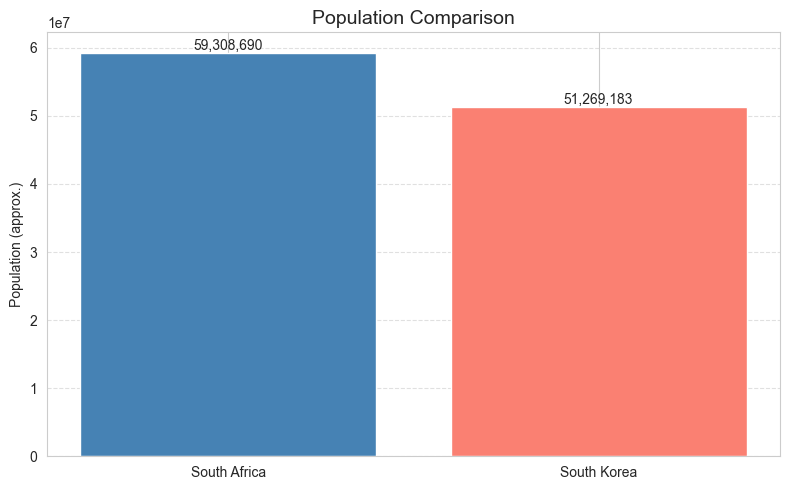

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('results/prepared_for_3_ex.csv')

# Select countries
countries = ['South Korea', 'South Africa']

# Get population data (latest entry per country)
population_df = df[df['country_name'].isin(countries)].drop_duplicates('country_name')[['country_name', 'population']]

# Prepare data
labels = population_df['country_name'].tolist()
values = population_df['population'].tolist()

# Create plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, values, color=['steelblue', 'salmon'])
plt.title('Population Comparison', fontsize=14)
plt.ylabel('Population (approx.)')
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add values on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


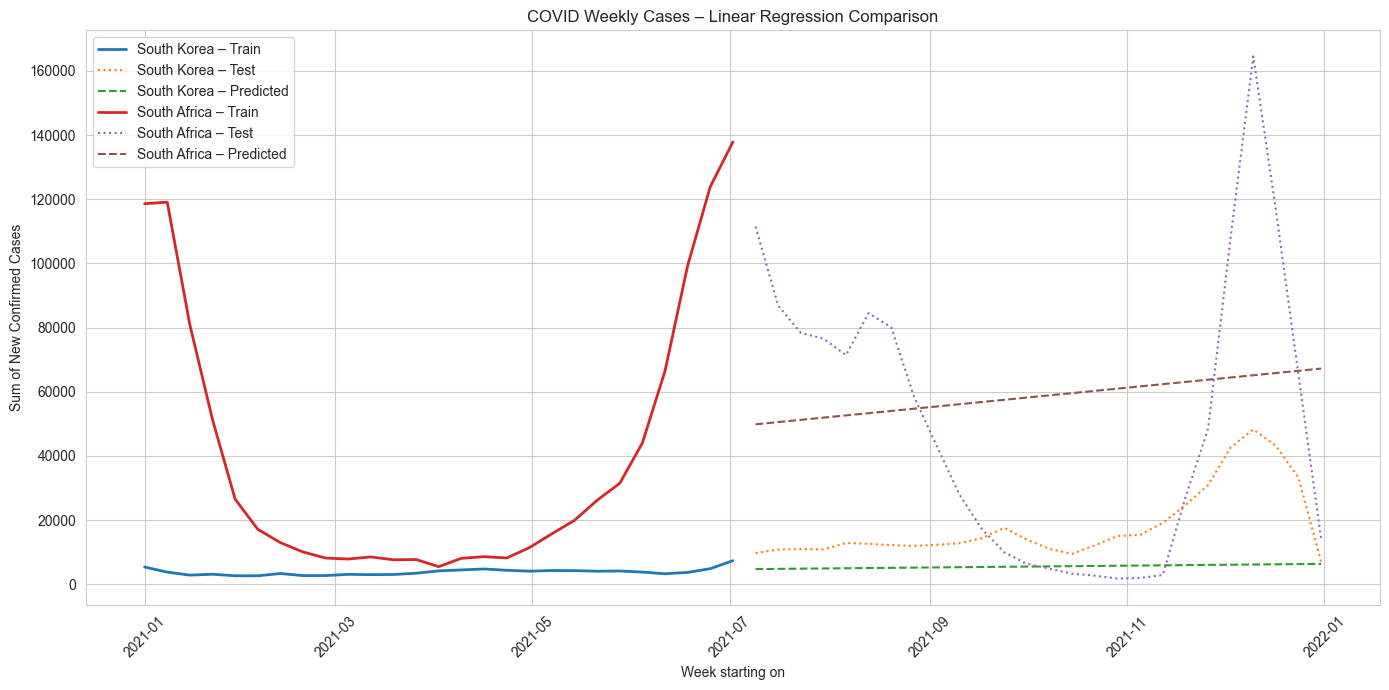

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Wybierz kraje i daty
# countries = ['Ukraine', 'Algeria']
countries = ['South Korea', 'South Africa']
start_date = '2021-01-01'
end_date = '2022-01-01'

plt.figure(figsize=(14, 7))

for country in countries:
    # Filtracja
    df_country = df[(df['country_name'] == country) &
                    (df['date'] >= start_date) &
                    (df['date'] <= end_date)].copy()

    # Tygodnie
    df_country = df_country.sort_values('date')
    df_country['week'] = ((df_country['date'] - df_country['date'].min()).dt.days // 7)
    
    weekly_df = df_country.groupby('week').agg({
        'new_confirmed': 'sum',
        'date': 'min'
    }).reset_index()

    # Automatyczny podział na pół
    max_week = weekly_df['week'].max()
    split_week = max_week // 2

    train_weeks = weekly_df[weekly_df['week'] <= split_week]
    test_weeks = weekly_df[weekly_df['week'] > split_week]

    X_train = train_weeks[['week']]
    y_train = train_weeks['new_confirmed']
    X_test = test_weeks[['week']]
    y_test = test_weeks['new_confirmed']

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Wykres
    plt.plot(train_weeks['date'], y_train, label=f'{country} – Train', linewidth=2)
    plt.plot(test_weeks['date'], y_test, label=f'{country} – Test', linestyle='dotted')
    plt.plot(test_weeks['date'], y_pred, label=f'{country} – Predicted', linestyle='--')

plt.xlabel('Week starting on')
plt.ylabel('Sum of New Confirmed Cases')
plt.title('COVID Weekly Cases – Linear Regression Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


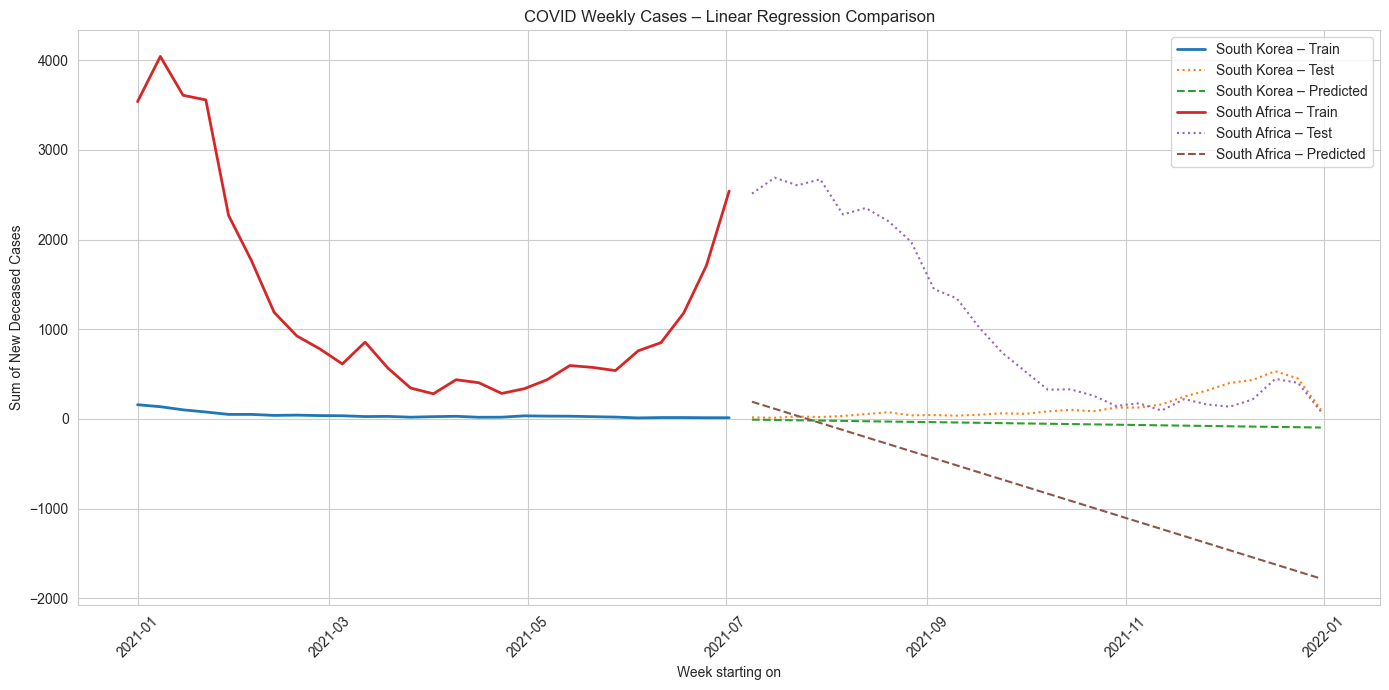

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Wybierz kraje i daty
# countries = ['Ukraine', 'Algeria']
countries = ['South Korea', 'South Africa']
start_date = '2021-01-01'
end_date = '2022-01-01'

plt.figure(figsize=(14, 7))

for country in countries:
    # Filtracja
    df_country = df[(df['country_name'] == country) &
                    (df['date'] >= start_date) &
                    (df['date'] <= end_date)].copy()

    # Tygodnie
    df_country = df_country.sort_values('date')
    df_country['week'] = ((df_country['date'] - df_country['date'].min()).dt.days // 7)
    
    weekly_df = df_country.groupby('week').agg({
        'new_deceased': 'sum',
        'date': 'min'
    }).reset_index()

    # Automatyczny podział na pół
    max_week = weekly_df['week'].max()
    split_week = max_week // 2

    train_weeks = weekly_df[weekly_df['week'] <= split_week]
    test_weeks = weekly_df[weekly_df['week'] > split_week]

    X_train = train_weeks[['week']]
    y_train = train_weeks['new_deceased']
    X_test = test_weeks[['week']]
    y_test = test_weeks['new_deceased']

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Wykres
    plt.plot(train_weeks['date'], y_train, label=f'{country} – Train', linewidth=2)
    plt.plot(test_weeks['date'], y_test, label=f'{country} – Test', linestyle='dotted')
    plt.plot(test_weeks['date'], y_pred, label=f'{country} – Predicted', linestyle='--')

plt.xlabel('Week starting on')
plt.ylabel('Sum of New Deceased Cases')
plt.title('COVID Weekly Cases – Linear Regression Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Tutaj w jeszcze bardziej dobitny sposób brakuje ograniczania "zejścia poniżej 0". Widać tu niewątpliwie że regresja liniowa naprawdę nie powinna być użyta do tego typu danych... 


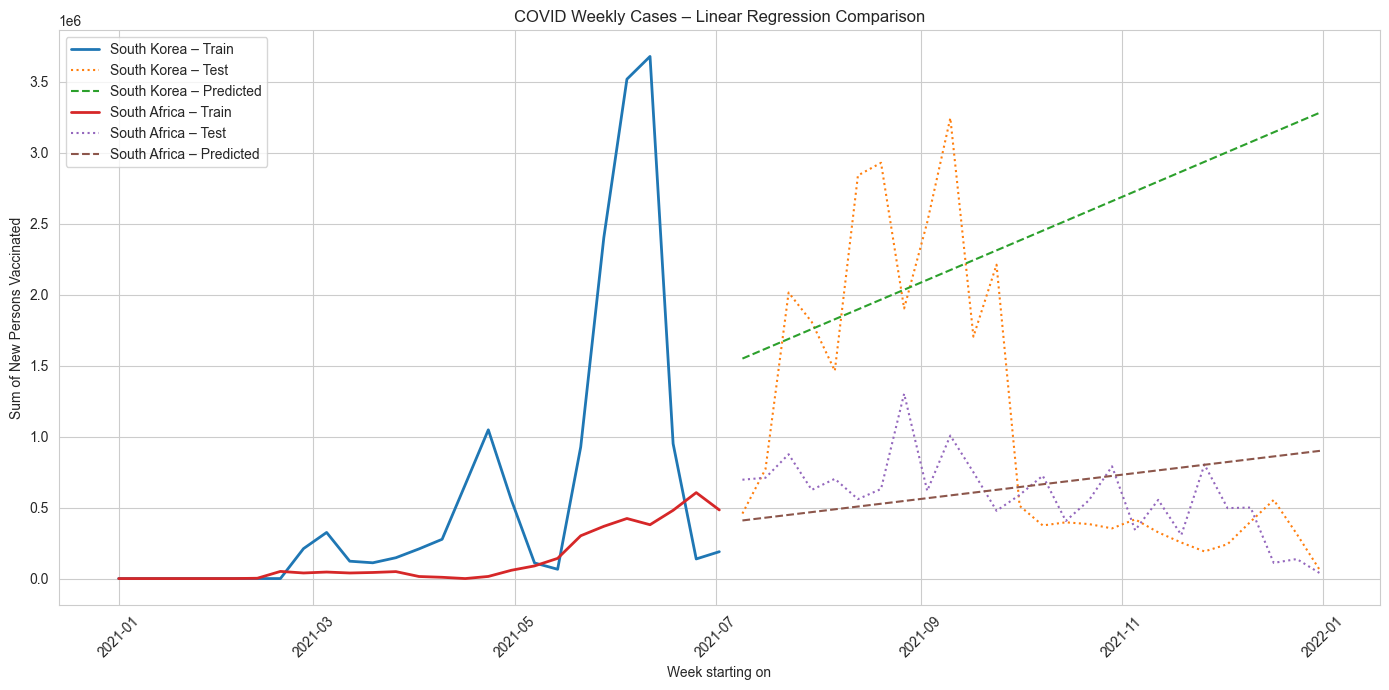

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Wybierz kraje i daty
# countries = ['Ukraine', 'Algeria']
countries = ['South Korea', 'South Africa']
start_date = '2021-01-01'
end_date = '2022-01-01'

plt.figure(figsize=(14, 7))

for country in countries:
    # Filtracja
    df_country = df[(df['country_name'] == country) &
                    (df['date'] >= start_date) &
                    (df['date'] <= end_date)].copy()

    # Tygodnie
    df_country = df_country.sort_values('date')
    df_country['week'] = ((df_country['date'] - df_country['date'].min()).dt.days // 7)
    
    weekly_df = df_country.groupby('week').agg({
        'new_persons_vaccinated': 'sum',
        'date': 'min'
    }).reset_index()

    # Automatyczny podział na pół
    max_week = weekly_df['week'].max()
    split_week = max_week // 2

    train_weeks = weekly_df[weekly_df['week'] <= split_week]
    test_weeks = weekly_df[weekly_df['week'] > split_week]

    X_train = train_weeks[['week']]
    y_train = train_weeks['new_persons_vaccinated']
    X_test = test_weeks[['week']]
    y_test = test_weeks['new_persons_vaccinated']

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Wykres
    plt.plot(train_weeks['date'], y_train, label=f'{country} – Train', linewidth=2)
    plt.plot(test_weeks['date'], y_test, label=f'{country} – Test', linestyle='dotted')
    plt.plot(test_weeks['date'], y_pred, label=f'{country} – Predicted', linestyle='--')

plt.xlabel('Week starting on')
plt.ylabel('Sum of New Persons Vaccinated')
plt.title('COVID Weekly Cases – Linear Regression Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


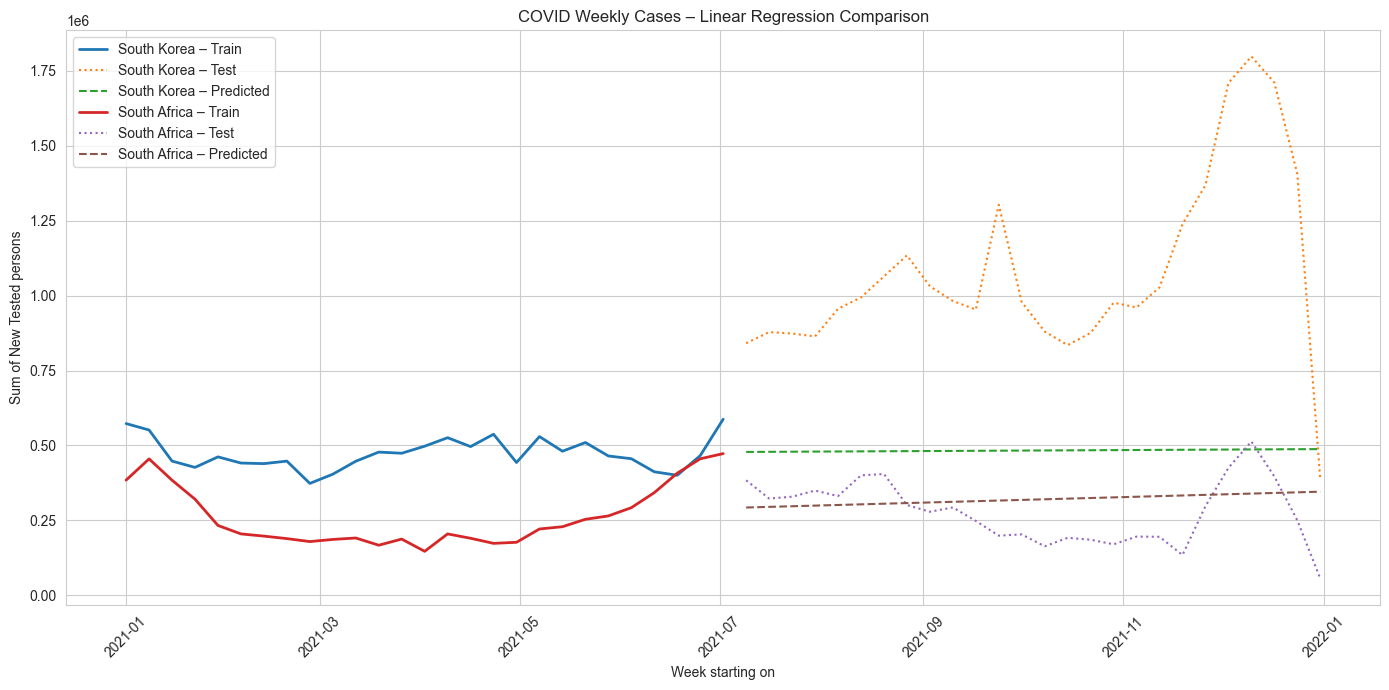

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Wybierz kraje i daty
# countries = ['Ukraine', 'Algeria']
countries = ['South Korea', 'South Africa']
start_date = '2021-01-01'
end_date = '2022-01-01'

plt.figure(figsize=(14, 7))

for country in countries:
    # Filtracja
    df_country = df[(df['country_name'] == country) &
                    (df['date'] >= start_date) &
                    (df['date'] <= end_date)].copy()

    # Tygodnie
    df_country = df_country.sort_values('date')
    df_country['week'] = ((df_country['date'] - df_country['date'].min()).dt.days // 7)
    
    weekly_df = df_country.groupby('week').agg({
        'new_tested': 'sum',
        'date': 'min'
    }).reset_index()

    # Automatyczny podział na pół
    max_week = weekly_df['week'].max()
    split_week = max_week // 2

    train_weeks = weekly_df[weekly_df['week'] <= split_week]
    test_weeks = weekly_df[weekly_df['week'] > split_week]

    X_train = train_weeks[['week']]
    y_train = train_weeks['new_tested']
    X_test = test_weeks[['week']]
    y_test = test_weeks['new_tested']

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Wykres
    plt.plot(train_weeks['date'], y_train, label=f'{country} – Train', linewidth=2)
    plt.plot(test_weeks['date'], y_test, label=f'{country} – Test', linestyle='dotted')
    plt.plot(test_weeks['date'], y_pred, label=f'{country} – Predicted', linestyle='--')

plt.xlabel('Week starting on')
plt.ylabel('Sum of New Tested persons')
plt.title('COVID Weekly Cases – Linear Regression Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


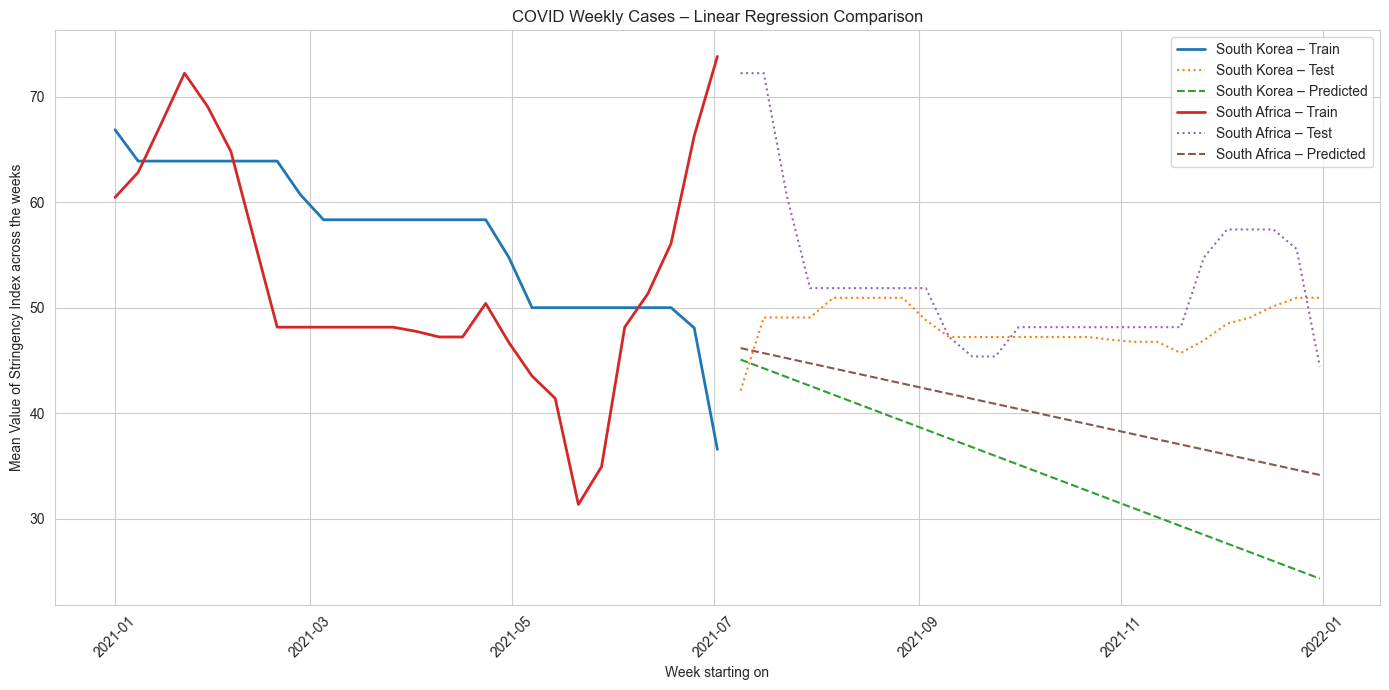

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Załaduj dane
df = pd.read_csv('results/prepared_for_3_ex.csv', parse_dates=['date'])

# Wybierz kraje i daty
# countries = ['Ukraine', 'Algeria']
countries = ['South Korea', 'South Africa']
start_date = '2021-01-01'
end_date = '2022-01-01'

plt.figure(figsize=(14, 7))

for country in countries:
    # Filtracja
    df_country = df[(df['country_name'] == country) &
                    (df['date'] >= start_date) &
                    (df['date'] <= end_date)].copy()

    # Tygodnie
    df_country = df_country.sort_values('date')
    df_country['week'] = ((df_country['date'] - df_country['date'].min()).dt.days // 7)
    
    weekly_df = df_country.groupby('week').agg({
        'stringency_index': 'mean',
        'date': 'min'
    }).reset_index()

    # Automatyczny podział na pół
    max_week = weekly_df['week'].max()
    split_week = max_week // 2

    train_weeks = weekly_df[weekly_df['week'] <= split_week]
    test_weeks = weekly_df[weekly_df['week'] > split_week]

    X_train = train_weeks[['week']]
    y_train = train_weeks['stringency_index']
    X_test = test_weeks[['week']]
    y_test = test_weeks['stringency_index']

    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Wykres
    plt.plot(train_weeks['date'], y_train, label=f'{country} – Train', linewidth=2)
    plt.plot(test_weeks['date'], y_test, label=f'{country} – Test', linestyle='dotted')
    plt.plot(test_weeks['date'], y_pred, label=f'{country} – Predicted', linestyle='--')

plt.xlabel('Week starting on')
plt.ylabel('Mean Value of Stringency Index across the weeks')
plt.title('COVID Weekly Cases – Linear Regression Comparison')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


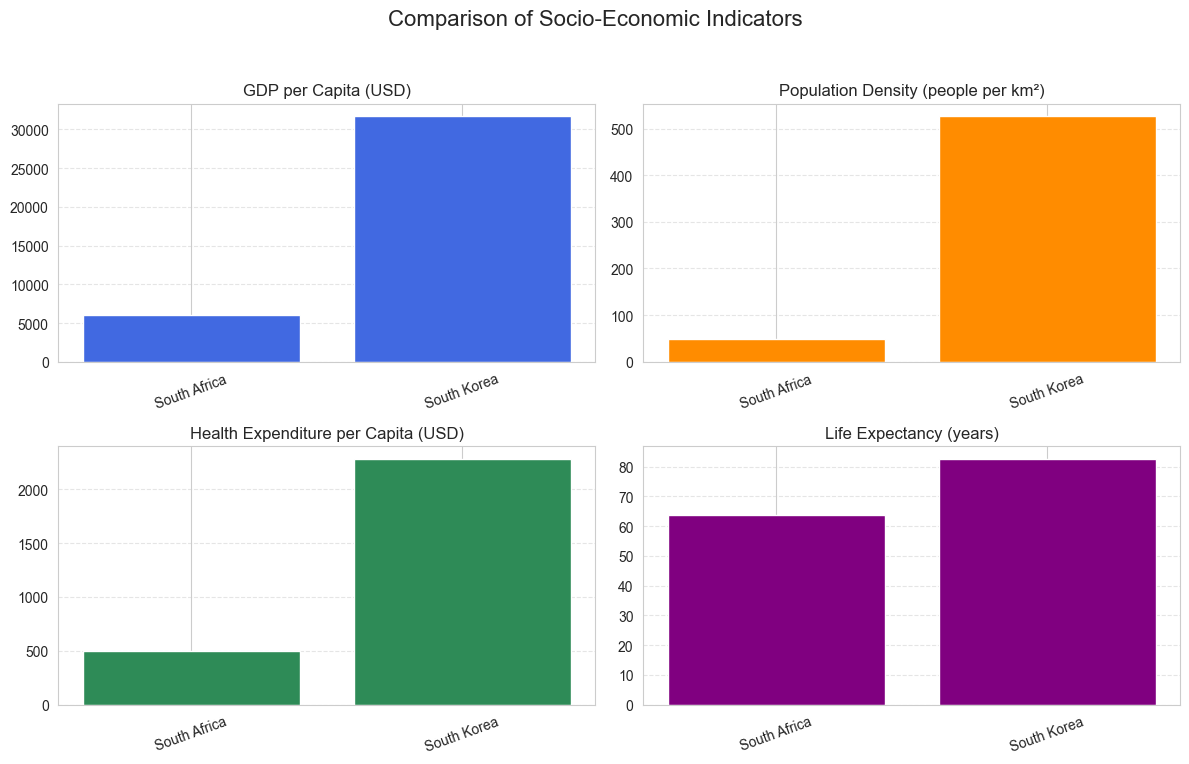

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('results/prepared_for_3_ex.csv')

# Select countries to compare
countries = ['South Korea', 'South Africa']

# Filter and keep only one row per country with the latest data
summary = df[df['country_name'].isin(countries)].drop_duplicates('country_name')[[
    'country_name',
    'gdp_per_capita_usd',
    'population density',
    'health_expenditure_usd',
    'life_expectancy'
]]

# Assign to variables
labels = summary['country_name'].tolist()
gdp = summary['gdp_per_capita_usd'].tolist()
density = summary['population density'].tolist()
health = summary['health_expenditure_usd'].tolist()
life = summary['life_expectancy'].tolist()

# Create plots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Comparison of Socio-Economic Indicators', fontsize=16)

axs[0, 0].bar(labels, gdp, color='royalblue')
axs[0, 0].set_title('GDP per Capita (USD)')

axs[0, 1].bar(labels, density, color='darkorange')
axs[0, 1].set_title('Population Density (people per km²)')

axs[1, 0].bar(labels, health, color='seagreen')
axs[1, 0].set_title('Health Expenditure per Capita (USD)')

axs[1, 1].bar(labels, life, color='purple')
axs[1, 1].set_title('Life Expectancy (years)')

for ax in axs.flat:
    ax.set_ylabel('')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=20)
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


<h3> Powyższe wykresy pokazują wprost, że mimo podobnej populacji krajów, wyniki dotyczące walki koronawirusa się różnią.

Wniosek jest taki - Korea południowa radziała sobie o wiele lepiej z walką z koronawirusem, widać to zarówno na podstawie wartości dotyczących nowych przypadków jak i przypadków śmiertelnych. 

Gęstość zaludnienia Koreii powinien negatywnie wpłynąć na zarażenia, jednak rząd skuteczniej operował obostrzeniami - które zapewne z racji na kulture azjatycką nie stawnowiły "problemu". Widać natomiast, że liczba wykonywanych testów w obydwu krajach jest bardzo zbliżona co pokazuje, że samo testowanie obywateli nie jest dostateczną metodą walczenia z koronawirusem. 

Ale, w przypadku trzeciego wzrostu zachorowań w okolicach grudnia 2022 widać, że Korea nie zareagowała dostatecznie mocno jak i również ewdentnie szczepionki okazały się za słabe, gdyż wartości przypadków śmiertelnych są w tym okresie wyższe niż w Południowej Afryce.
<h3>

<h4> Dodatkowo widać ponownie, że regresja liniowa nie nadaje się do zastosowań predykcyjnych i poza kilkoma przypadkami takimi jak ilość szczepionych osób w RPA oraz ilość wykonywanych testów  w tym kraju. <h4>